<a href="https://colab.research.google.com/github/mitsouma/IOT_Anomalies_Detection_System_Based_on_Tensor_Decomposition/blob/main/Last_version_Pipeline_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
import numpy as np
import pandas as pd
from tensorly.decomposition import parafac,non_negative_parafac
import tensorly as tl
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorly import unfold, fold
from tensorly.tenalg import khatri_rao
from numpy.linalg import lstsq
from tensorly.cp_tensor import cp_to_tensor
from sklearn.metrics import accuracy_score, log_loss
import time
from datetime import datetime
from sklearn.model_selection import train_test_split,KFold,cross_val_score
import torch
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import (confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve, auc,
                           accuracy_score, precision_score, recall_score, f1_score,
                           ConfusionMatrixDisplay)
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import random


In [ ]:
pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.0 MB/s eta 0:00:00


"""
This pipeline is designed to detect anomalies in network traffic using a tensor-based deep learning approach.

Steps and Objectives:
---------------------
1. **Preprocessing & Tensor Construction**:
   - Multivariate network traffic data is aggregated over time windows.
   - A 4D tensor is built with dimensions: [Time_Window, Src IP, Dst IP,featues].

2. **Tensor Decomposition (CP)**:
   - The tensor is decomposed using CP (CANDECOMP/PARAFAC) to extract the underlying structure (normal behavior).
   - This reveals low-rank patterns, which capture typical traffic patterns.

3. **Reconstruction & Residual Calculation**:
   - We take the training tenssor and we compute its CP decomposition
   - Residuals are computed as the difference between the measure of the train tensor and the projection of this measure in the latent space.
4. **Anomaly Scoring**:
Since our goal aim to detect DDoS and DOS attack so:
   - Scores are aggregated per destination IP (`Dst IP`) and feature.
   - These scores reflect the degree of deviation from normal patterns.

5. **Deep Learning Classification**:
   - The aggregated anomaly scores are used as input to a neural network.
   - If labeled data is available, the model is trained in a supervised way to classify normal vs anomalous flows.
   - If labels are absent, an autoencoder is trained to learn normal behavior and detect deviations.

6. **Prediction**:
   - New traffic data is processed through the same pipeline.
   - The trained model predicts anomaly scores or binary classifications.

Main Goal:
----------
To detect abnormal network behavior in the IOT_data  by modeling traffic patterns as tensors, identifying deviations, and classifying them using deep learning models.
"""


In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
tl.set_backend('pytorch')

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Define the dataset**

In [ ]:
df1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic.pcap_Flow.csv')
df2=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic1.pcap_Flow.csv')
df3=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic2.pcap_Flow.csv')
df4=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic3.pcap_Flow.csv')
df5=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Anomalies_fbased/DDoS-HTTP_Flood-.pcap_Flow.csv')
df6=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Anomalies_fbased/DoS-HTTP_Flood.pcap_Flow.csv')
df7=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Anomalies_fbased/DoS-HTTP_Flood1.pcap_Flow.csv')

In [ ]:
df1['label']=0
df2['label']=0
df3['label']=0
df4['label']=0
df5['label']=1
df6['label']=1
df7['label']=1

In [ ]:
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df3.replace([np.inf, -np.inf], np.nan, inplace=True)
df4.replace([np.inf, -np.inf], np.nan, inplace=True)
df5.replace([np.inf, -np.inf], np.nan, inplace=True)
df6.replace([np.inf, -np.inf], np.nan, inplace=True)
df7.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
#Drop na
for df in [df1,df2,df3,df4,df5,df6,df7]:
    r=df.isna().sum()
    print("nan for :are :",r[r>0])

nan for :are : Flow Bytes/s      35
Flow Packets/s    35
dtype: int64
nan for :are : Flow Bytes/s      35
Flow Packets/s    35
dtype: int64
nan for :are : Flow Bytes/s      45
Flow Packets/s    45
dtype: int64
nan for :are : Flow Bytes/s      17
Flow Packets/s    17
dtype: int64
nan for :are : Flow Bytes/s      1123
Flow Packets/s    1123
dtype: int64
nan for :are : Flow Bytes/s      40786
Flow Packets/s    40786
dtype: int64
nan for :are : Flow Bytes/s      38735
Flow Packets/s    38735
dtype: int64


In [ ]:
#Shape of each dataset
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)
print(df6.shape)
print(df7.shape)

(183630, 85)
(84526, 85)
(91279, 85)
(38895, 85)
(505720, 85)
(932513, 85)
(710231, 85)


In [ ]:
#Drop duplicated rows
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)
df3.drop_duplicates(inplace=True)
df4.drop_duplicates(inplace=True)
df5.drop_duplicates(inplace=True)
df6.drop_duplicates(inplace=True)
df7.drop_duplicates(inplace=True)

In [ ]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)
df4.dropna(inplace=True)
df5.dropna(inplace=True)
df6.dropna(inplace=True)
df7.dropna(inplace=True)

In [ ]:
#Convert timestamp
df1['Timestamp']=pd.to_datetime(df1['Timestamp'])
df2['Timestamp']=pd.to_datetime(df2['Timestamp'])
df3['Timestamp']=pd.to_datetime(df3['Timestamp'])
df4['Timestamp']=pd.to_datetime(df4['Timestamp'])
df5['Timestamp']=pd.to_datetime(df5['Timestamp'])
df6['Timestamp']=pd.to_datetime(df6['Timestamp'])
df7['Timestamp']=pd.to_datetime(df7['Timestamp'])

In [ ]:
#Extract days
df1['Jour']=df1['Timestamp'].dt.date
df2['Jour']=df2['Timestamp'].dt.date
df3['Jour']=df3['Timestamp'].dt.date
df4['Jour']=df4['Timestamp'].dt.date
df5['Jour']=df5['Timestamp'].dt.date
df6['Jour']=df6['Timestamp'].dt.date
df7['Jour']=df7['Timestamp'].dt.date

In [ ]:
#Convert days
df1['Jour']=pd.to_datetime(df1['Jour'])
df2['Jour']=pd.to_datetime(df2['Jour'])
df3['Jour']=pd.to_datetime(df3['Jour'])
df4['Jour']=pd.to_datetime(df4['Jour'])
df5['Jour']=pd.to_datetime(df5['Jour'])
df6['Jour']=pd.to_datetime(df6['Jour'])
df7['Jour']=pd.to_datetime(df7['Jour'])

In [ ]:
df5_day_1=df5[df5['Jour']=='2022-09-14']
df5_day_2=df5[df5['Jour']=='2022-11-07']
df6_day_1=df6[df6['Jour']=='2022-08-08']
df6_day_2=df6[df6['Jour']=='2022-09-08']

In [ ]:
#Extract time
df1['Heure']=df1['Timestamp'].dt.strftime('%H:%M:%S')
df2['Heure']=df2['Timestamp'].dt.strftime('%H:%M:%S')
df3['Heure']=df3['Timestamp'].dt.strftime('%H:%M:%S')
df4['Heure']=df4['Timestamp'].dt.strftime('%H:%M:%S')
df5_day_1['Heure']=df5_day_1['Timestamp'].dt.strftime('%H:%M:%S')
df5_day_2['Heure']=df5_day_2['Timestamp'].dt.strftime('%H:%M:%S')
df6_day_1['Heure']=df6_day_1['Timestamp'].dt.strftime('%H:%M:%S')
df6_day_2['Heure']=df6_day_2['Timestamp'].dt.strftime('%H:%M:%S')
df7['Heure']=df7['Timestamp'].dt.strftime('%H:%M:%S')

In [ ]:
#Create a relative time
df1['relative_time']=df1['Timestamp']-df1['Timestamp'].min()
df2['relative_time']=df2['Timestamp']-df2['Timestamp'].min()
df3['relative_time']=df3['Timestamp']-df3['Timestamp'].min()
df4['relative_time']=df4['Timestamp']-df4['Timestamp'].min()
df5_day_1['relative_time']=df5_day_1['Timestamp']-df5_day_1['Timestamp'].min()
df5_day_2['relative_time']=df5_day_2['Timestamp']-df5_day_2['Timestamp'].min()
df6_day_1['relative_time']=df6_day_1['Timestamp']-df6_day_1['Timestamp'].min()
df6_day_2['relative_time']=df6_day_2['Timestamp']-df6_day_2['Timestamp'].min()
df7['relative_time']=df7['Timestamp']-df7['Timestamp'].min()

In [ ]:
#Normal filter
hours = df1['relative_time'].dt.total_seconds() / 3600
mask_3h = hours <= 1
df_3h = df1[mask_3h]
#Train filter
hours_t = df4['relative_time'].dt.total_seconds() / 3600
mask_3h_t = hours_t <= 1
df_3h_t = df4[mask_3h_t]
#Test filter
hours_3h_test = df3['relative_time'].dt.total_seconds() / 3600
mask_3h_test = hours_3h_test <= 1
df_3h_test = df3[mask_3h_test]
#Anomalous filter
hours_3h_test_a = df5_day_2['relative_time'].dt.total_seconds() / 3600
mask_3h_test_a = hours_3h_test_a <= 1
df_3h_test_a = df5_day_2[mask_3h_test_a]
df7_2h=df7[df7['relative_time']<pd.Timedelta(hours=1)]

# DATA CONSTRUCTION

In [ ]:
#Consider for as normal_data "Benign 1 ":
df_normal=df_3h
#Training data:
df_train=pd.concat([df_3h_t,df5_day_1,df7_2h],axis=0)
df_test=pd.concat([df_3h_test,df_3h_test_a,df6_day_2],axis=0)

In [ ]:
scale=StandardScaler().fit(df_normal[['Flow Duration','Flow Packets/s','Flow Bytes/s']])

In [ ]:
# Original code for scaling and creating new dataframes
df_normal_scaled=scale.transform(df_normal[['Flow Duration','Flow Packets/s','Flow Bytes/s']])
df_train_scaled=scale.transform(df_train[['Flow Duration','Flow Packets/s','Flow Bytes/s']])
df_test_scaled=scale.transform(df_test[['Flow Duration','Flow Packets/s','Flow Bytes/s']])

df_normal_scaled=pd.DataFrame(df_normal_scaled,columns=['Flow Duration','Flow Packets/s','Flow Bytes/s'])
df_train_scaled=pd.DataFrame(df_train_scaled,columns=['Flow Duration','Flow Packets/s','Flow Bytes/s'])
df_test_scaled=pd.DataFrame(df_test_scaled,columns=['Flow Duration','Flow Packets/s','Flow Bytes/s'])

# Reset the index of the original dataframes to ensure alignment
# This creates a new default integer index
df_normal = df_normal.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Now assign the columns from the original dataframes with reset indices
df_normal_scaled[['relative_time','Src IP','Dst IP','label']]=df_normal[['relative_time','Src IP','Dst IP','label']]
df_train_scaled[['relative_time','Src IP','Dst IP','label']]=df_train[['relative_time','Src IP','Dst IP','label']]
df_test_scaled[['relative_time','Src IP','Dst IP','label']]=df_test[['relative_time','Src IP','Dst IP','label']]

In [ ]:
df_normal_scaled

,Flow Duration,Flow Packets/s,Flow Bytes/s,relative_time,Src IP,Dst IP,label
0,-0.478249,-0.081498,-0.063786,0 days 00:00:01,192.168.137.41,157.249.81.141,0
1,-0.478266,-0.081498,-0.063869,0 days 00:00:01,192.168.137.41,157.249.81.141,0
2,-0.478229,-0.081499,-0.063786,0 days 00:00:03,192.168.137.41,157.249.81.141,0
3,-0.478238,-0.081499,-0.063869,0 days 00:00:03,192.168.137.41,157.249.81.141,0
4,-0.478216,-0.081500,-0.063786,0 days 00:00:04,192.168.137.41,157.249.81.141,0
...,...,...,...,...,...,...,...
21583,-0.172776,-0.081801,-0.063936,0 days 00:49:57,192.168.137.249,192.168.137.1,0
21584,-0.478930,-0.081655,-0.063816,0 days 00:56:16,192.168.137.249,8.8.8.8,0
21585,-0.484441,-0.081442,-0.063807,0 days 00:13:34,192.168.137.224,192.168.137.1,0
21586,-0.485431,-0.080628,-0.062497,0 days 00:54:43,192.168.137.249,8.8.4.4,0


# TENSOR CONSTRUCTION

In [ ]:
def build_global_ip_mappings(*dfs):
    all_src_ips = set()
    all_dst_ips = set()

    for df in dfs:
        all_src_ips.update(df['Src IP'].unique())
        all_dst_ips.update(df['Dst IP'].unique())

    src_ip_to_idx = {ip: idx for idx, ip in enumerate(sorted(all_src_ips))}
    dst_ip_to_idx = {ip: idx for idx, ip in enumerate(sorted(all_dst_ips))}

    return src_ip_to_idx, dst_ip_to_idx

In [ ]:
src_ip_to_idx, dst_ip_to_idx=build_global_ip_mappings(df_normal,df_train,df_test)

In [ ]:
def create_graph_tensor(df, src_ip_to_idx, dst_ip_to_idx, window_size=300):
    # 1. Detect device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 2. Create time windows based on relative time
    df['time_window'] = df['relative_time'].astype(np.int64) // (10**9 * window_size)
    time_windows = np.sort(df['time_window'].unique())

    # 3. Map IPs and time windows to indices
    df['t_idx'] = pd.Categorical(df['time_window'], categories=time_windows).codes
    df['src_idx'] = df['Src IP'].map(src_ip_to_idx)
    df['dst_idx'] = df['Dst IP'].map(dst_ip_to_idx)

    # 4. Drop rows where mapping failed
    df = df.dropna(subset=['src_idx', 'dst_idx'])
    df['src_idx'] = df['src_idx'].astype(int)
    df['dst_idx'] = df['dst_idx'].astype(int)

    # 5. Aggregate statistics for each (time, src, dst) triplet
    grouped = df.groupby(['t_idx', 'src_idx', 'dst_idx'], sort=False).agg(
        count=('Flow Bytes/s', 'count'),
        bytes_sum=('Flow Bytes/s', 'sum'),
        duration_mean=('Flow Duration', 'mean'),
        pps_sum=('Flow Packets/s', 'sum')
    ).reset_index()

    # 6. Initialize tensor directly
    tensor = torch.zeros(
        (len(time_windows), len(src_ip_to_idx), len(dst_ip_to_idx), 4),
        dtype=torch.float32,
        device=device
    )

    # 7. Efficiently assign aggregated values
    t_idx = torch.tensor(grouped['t_idx'].values, dtype=torch.long, device=device)
    s_idx = torch.tensor(grouped['src_idx'].values, dtype=torch.long, device=device)
    d_idx = torch.tensor(grouped['dst_idx'].values, dtype=torch.long, device=device)

    tensor.index_put_((t_idx, s_idx, d_idx, torch.zeros_like(t_idx, dtype=torch.long)),
                      torch.tensor(grouped['count'].values, dtype=torch.float32, device=device))

    tensor.index_put_((t_idx, s_idx, d_idx, torch.ones_like(t_idx, dtype=torch.long)),
                      torch.tensor(grouped['bytes_sum'].values, dtype=torch.float32, device=device))

    tensor.index_put_((t_idx, s_idx, d_idx, torch.full_like(t_idx, 2, dtype=torch.long)),
                      torch.tensor(grouped['duration_mean'].values, dtype=torch.float32, device=device))

    tensor.index_put_((t_idx, s_idx, d_idx, torch.full_like(t_idx, 3, dtype=torch.long)),
                      torch.tensor(grouped['pps_sum'].values, dtype=torch.float32, device=device))

    print("✅ Tensor successfully created | shape:", tensor.shape)
    return tensor, time_windows


In [ ]:
tensor_normal, time_normal = create_graph_tensor(df_normal_scaled, src_ip_to_idx, dst_ip_to_idx)
tensor_train, time_train = create_graph_tensor(df_train_scaled, src_ip_to_idx, dst_ip_to_idx)
tensor_test, time_test = create_graph_tensor(df_test_scaled, src_ip_to_idx, dst_ip_to_idx)

Using device: cuda
✅ Tensor successfully created | shape: torch.Size([13, 822, 1313, 4])
Using device: cuda
✅ Tensor successfully created | shape: torch.Size([12, 822, 1313, 4])
Using device: cuda
✅ Tensor successfully created | shape: torch.Size([13, 822, 1313, 4])


# Tensor Normalisation

In [ ]:
def normalize_tensor_feature(tensor, feature_index):
    # Extract the feature slice
    feature_slice = tensor[:, :, :, feature_index]

    # Calculate min and max
    min_val =tensor[:,:,:,feature_index].min() # par feature
    max_val = tensor[:,:,:,feature_index].max() # par feature

    # Apply min-max normalization
    if max_val - min_val > 0:
        normalized_slice = (feature_slice - min_val) / (max_val - min_val)
    else:
        # All values are the same
        normalized_slice = feature_slice - min_val  # results in all zeros

    # Replace the original feature with the normalized one
    tensor[:, :, :, feature_index] = normalized_slice

    return tensor


In [ ]:
tensor_normal = normalize_tensor_feature(tensor_normal, 0)
tensor_train = normalize_tensor_feature(tensor_train, 0)
tensor_test = normalize_tensor_feature(tensor_test, 0)

In [ ]:
tensor_normal = normalize_tensor_feature(tensor_normal, 1)
tensor_train = normalize_tensor_feature(tensor_train, 1)
tensor_test = normalize_tensor_feature(tensor_test, 1)

In [ ]:
tensor_normal = normalize_tensor_feature(tensor_normal, 2)
tensor_train = normalize_tensor_feature(tensor_train, 2)
tensor_test = normalize_tensor_feature(tensor_test, 2)

In [ ]:
tensor_normal = normalize_tensor_feature(tensor_normal, 3)
tensor_train = normalize_tensor_feature(tensor_train, 3)
tensor_test = normalize_tensor_feature(tensor_test, 3)

# COMPRESSION GRAPH

In [ ]:
def Tensor_decomposition(tensor,rank):

    factors_normal = parafac(tensor_normal, rank=rank, init='random',random_state=52, n_iter_max=100,l2_reg=1e-8)
    # Reconstruction
    reconstruction = cp_to_tensor(factors_normal)
    error=tl.norm(tensor_normal-reconstruction)/tl.norm(tensor_normal)
    print("error=",error)
    print("error=",error.item())

    return factors_normal,error

**Normal Projection**

In [ ]:
def normal_space_projection(tensor_input, tensor_ref):
    # Extract CP factors from reference
    _, (A_ref, B_ref, C_ref, D_ref) = tensor_ref
    rank = A_ref.shape[1]

    # Ensure tensors are on the correct device and dtype
    device = tensor_input.device
    tensor_input = tensor_input.to(torch.float32).to(device)
    B_ref = B_ref.to(torch.float32).to(device)
    C_ref = C_ref.to(torch.float32).to(device)
    D_ref = D_ref.to(torch.float32).to(device)

    # Compute Khatri-Rao product of the normalized factors
    kr_product = tl.tenalg.khatri_rao([B_ref, tl.tenalg.khatri_rao([C_ref, D_ref])]) #Sir here the shape is (IJK,rank)

    kr_pinv = torch.linalg.pinv(kr_product)  # Shape (IJK,rank)

    # Project each time slice onto the latent space
    T = tensor_input.shape[0]
    A_proj = torch.zeros((T, rank), dtype=torch.float32, device=device)

    for t in range(T):
        x_vec = tensor_input[t].reshape(1, -1)  # Shape: (1, I*J*K)
        A_proj[t] = x_vec @ kr_pinv.T  # Shape: (1, rank)

    # Reconstruct the projected tensor using lambdas_ref
    projected_tensor = cp_to_tensor((None, [A_proj, B_ref, C_ref, D_ref]))

    # Compute residual
    residual = tensor_input - projected_tensor

    print("✅ Projection completed.")
    print("Residual norm:", tl.norm(residual).item())

    return residual

# AGGREGATION_SCORING

In [ ]:
def aggregation_scoring_Source(residuals, mappings, df_with_labels, window_size=300):
    print("⏳ Step 4: Aggregating scores with labels...")

    # 1. Convert relative_time to time_window (as integer)
    df_with_labels = df_with_labels.copy()
    df_with_labels['time_window'] = df_with_labels['relative_time'].astype(np.int64) // (10**9 * window_size)

    # 2. Create label mapping: (Dst IP, time_window) -> label
    label_map = {}
    for _, row in df_with_labels.iterrows():
        key = (row['Dst IP'], int(row['time_window']))
        label = int(row['label']) if pd.notnull(row['label']) else 0
        label_map[key] = max(label_map.get(key, 0), label)

    # 3. Prepare dimensions
    try:
        residuals_np = tl.to_numpy(residuals)
    except Exception as e:
        raise ValueError("Failed to convert tensor to NumPy array: {}".format(e))

    idx_to_dst_ip = mappings.get('Dst_IP', {})
    idx_to_feature = mappings.get('features_names', {})

    if not idx_to_dst_ip or not idx_to_feature:
        raise ValueError("Required mappings are missing or incomplete.")

    time_dim, _, dst_dim, feat_dim = residuals_np.shape
    time_windows = list(range(time_dim))

    # 4. Aggregation and labeling
    aggregation = {}
    unknown_features = set()

    for t in range(time_dim):
        time_window = time_windows[t]
        for d in range(dst_dim):
            dst_ip = idx_to_dst_ip.get(d)
            if dst_ip is None:
                print(f"Warning: index {d} not found in Dst_IP mappings.")
                continue

            key = (dst_ip, time_window)
            if key not in aggregation:
                aggregation[key] = {
                    'Dst IP': dst_ip,
                    'time_windows': time_window,
                    'count': 0,
                    'bytes': 0,
                    'packets': 0,
                    'duration': 0,
                    'label': label_map.get(key, 0)
                }

            for f in range(feat_dim):
                feature_name = idx_to_feature.get(f, '').lower()

                score = np.sum(np.abs(residuals_np[t, :, d, f]))

                if 'count' in feature_name:
                    aggregation[key]['count'] += score
                elif 'bytes' in feature_name:
                    aggregation[key]['bytes'] += score
                elif 'packets' in feature_name:
                    aggregation[key]['packets'] += score
                elif 'duration' in feature_name:
                    aggregation[key]['duration'] += score
                else:
                    unknown_features.add(feature_name)

    if unknown_features:
        print(f"🟠 Warning: the following features were not recognized and were ignored: {sorted(unknown_features)}")

    df_scores = pd.DataFrame(list(aggregation.values()))
    print("✅ Score aggregation + labeling completed.")

    return df_scores


In [ ]:
features=['count','packets','duration','bytes']
def remove_outliers_iqr(df, features):
    cleaned_df = df.copy()
    for col in features:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filtrer les lignes en fonction de la colonne actuelle
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]
    return cleaned_df

In [ ]:
mappings={'Dst_IP':dst_ip_to_idx,'features_names':dict(enumerate(['count','bytes','packets','duration']))}

**Deep Learning Model**

In [ ]:
def build_and_train_binary_classifier(X_train, y_train, X_test, y_test, learning_rate=0.0001, batch_size=32, epochs=50):
    input_dim = X_train.shape[1]

    # Définition du modèle
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),


        layers.Dense(80, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),


        layers.Dense(60, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),


        layers.Dense(40, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),


        layers.Dense(20, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),


        layers.Dense(1, activation='sigmoid')

    ])

    # Compilation
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )


    # Fitting
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=batch_size, # Reduced batch size
        epochs=epochs,
        verbose=1
    )

    return model, history

**Run The pipeline**

# TESTING PHASE


=== Rank 1 ===
error= tensor(0.0167, device='cuda:0')
error= 0.01669645495712757
✅ Projection completed.
Residual norm: 1412.7999267578125
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6161 - auc_3: 0.8110 - loss: 0.7218 - val_accuracy: 0.9124 - val_auc_3: 0.9870 - val_loss: 0.4786
Epoch 2/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7710 - auc_3: 0.9627 - loss: 0.4943 - val_accuracy: 0.9944 - val_auc_3: 0.9886 - val_loss: 0.3541
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8687 - auc_3: 0.9751 - loss: 0.3834 - val_accuracy: 0.9946 - val_auc_3: 0.9862 - val_loss: 0.2524
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9230 - auc_3: 0.9877 - loss: 0.3133 - val_accuracy: 0.9948 - val_auc_3: 0.9818 - val_loss: 0.2173
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9512 - auc_3: 0.9909 - loss: 0.2498 - val_

<Figure size 600x500 with 0 Axes>

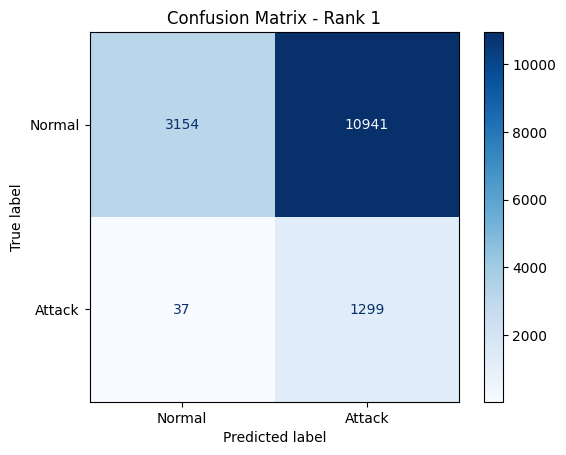

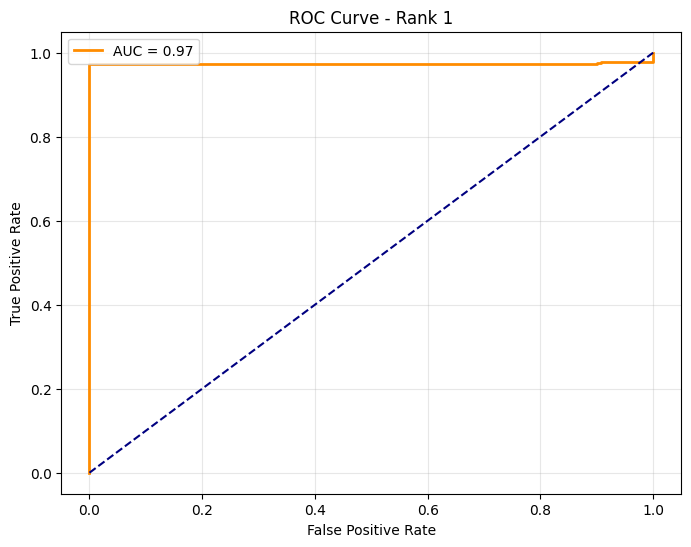

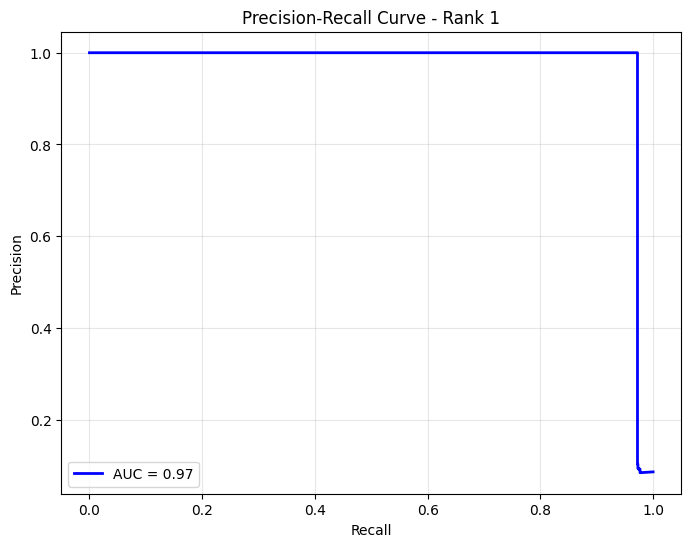


=== Rank 2 ===
error= tensor(0.0167, device='cuda:0')
error= 0.01665625534951687
✅ Projection completed.
Residual norm: 2172.85400390625
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5270 - auc_4: 0.5338 - loss: 0.8244 - val_accuracy: 0.9072 - val_auc_4: 0.5741 - val_loss: 0.5328
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6408 - auc_4: 0.6816 - loss: 0.6599 - val_accuracy: 0.9185 - val_auc_4: 0.7919 - val_loss: 0.3822
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7513 - auc_4: 0.7723 - loss: 0.5434 - val_accuracy: 0.9208 - val_auc_4: 0.9021 - val_loss: 0.3185
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8249 - auc_4: 0.8136 - loss: 0.4589 - val_accuracy: 0.9277 - val_auc_4: 0.9270 - val_loss: 0.2889
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8811 - auc_4: 0.8693 - loss: 0.3843 - val_ac

<Figure size 600x500 with 0 Axes>

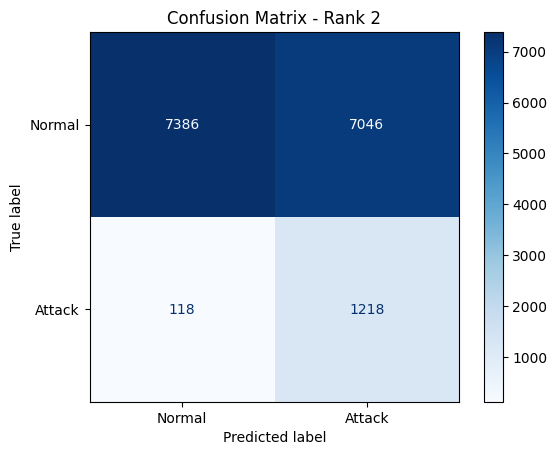

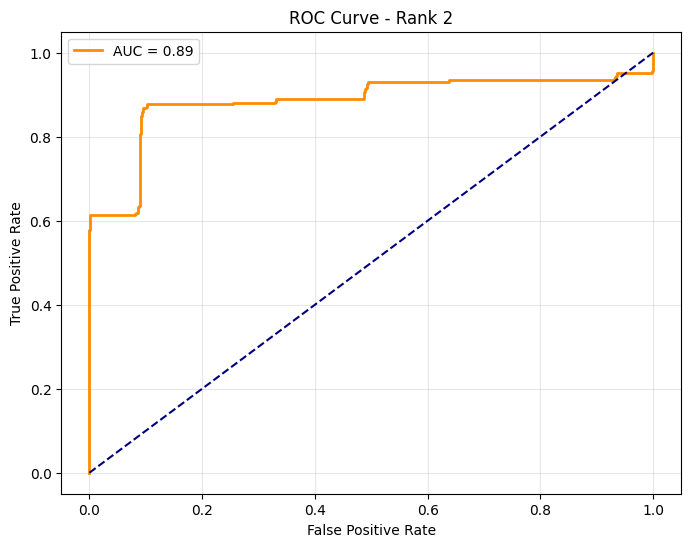

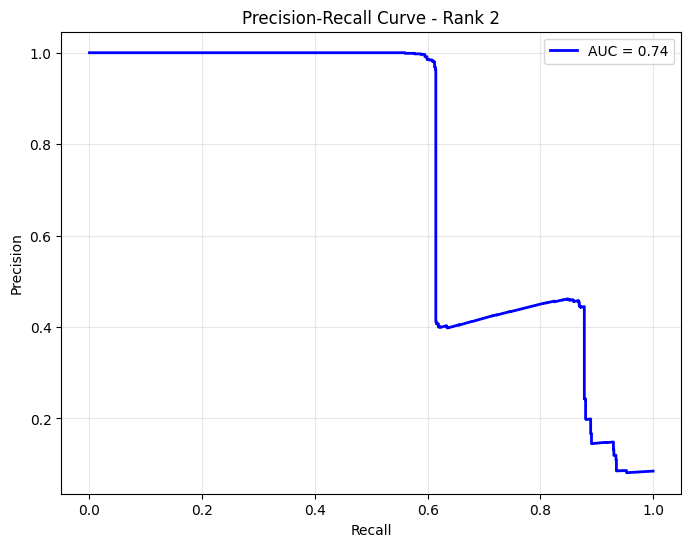


=== Rank 3 ===
error= tensor(0.0168, device='cuda:0')
error= 0.0168328694999218
✅ Projection completed.
Residual norm: 2113.135498046875
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5528 - auc_5: 0.5993 - loss: 0.7499 - val_accuracy: 0.8744 - val_auc_5: 0.8668 - val_loss: 0.5094
Epoch 2/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7648 - auc_5: 0.8713 - loss: 0.5249 - val_accuracy: 0.8959 - val_auc_5: 0.9752 - val_loss: 0.4223
Epoch 3/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8714 - auc_5: 0.9325 - loss: 0.4059 - val_accuracy: 0.9174 - val_auc_5: 0.9752 - val_loss: 0.3551
Epoch 4/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9283 - auc_5: 0.9632 - loss: 0.3257 - val_accuracy: 0.9177 - val_auc_5: 0.9845 - val_loss: 0.3080
Epoch 5/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9536 - auc_5: 0.9596 - loss: 0.2681 - val_ac

<Figure size 600x500 with 0 Axes>

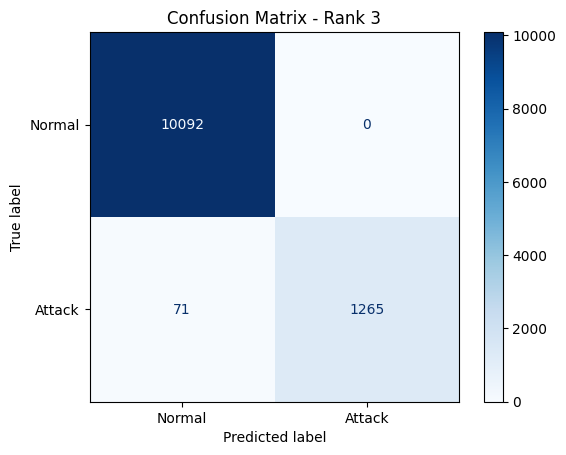

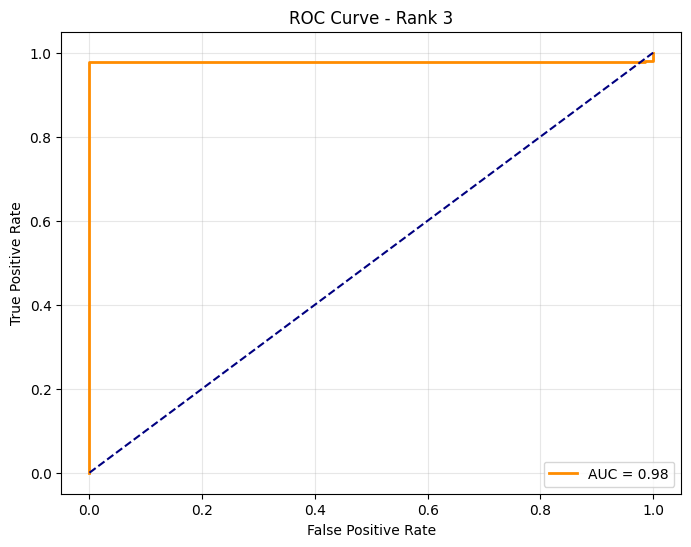

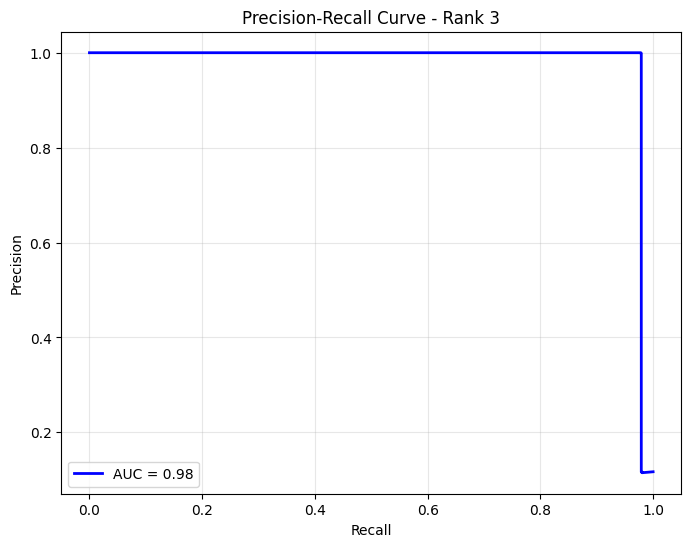


=== Rank 4 ===
error= tensor(0.0139, device='cuda:0')
error= 0.013890929520130157
✅ Projection completed.
Residual norm: 1554.8779296875
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.6454 - auc_6: 0.7171 - loss: 0.7319 - val_accuracy: 0.8940 - val_auc_6: 0.9571 - val_loss: 0.3350
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7795 - auc_6: 0.8432 - loss: 0.5087 - val_accuracy: 0.9022 - val_auc_6: 0.9041 - val_loss: 0.2906
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8475 - auc_6: 0.8788 - loss: 0.4122 - val_accuracy: 0.9161 - val_auc_6: 0.9648 - val_loss: 0.2460
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9006 - auc_6: 0.8968 - loss: 0.3327 - val_accuracy: 0.9182 - val_auc_6: 0.9544 - val_loss: 0.2427
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9065 - auc_6: 0.8823 - loss: 0.3057 - val_ac

<Figure size 600x500 with 0 Axes>

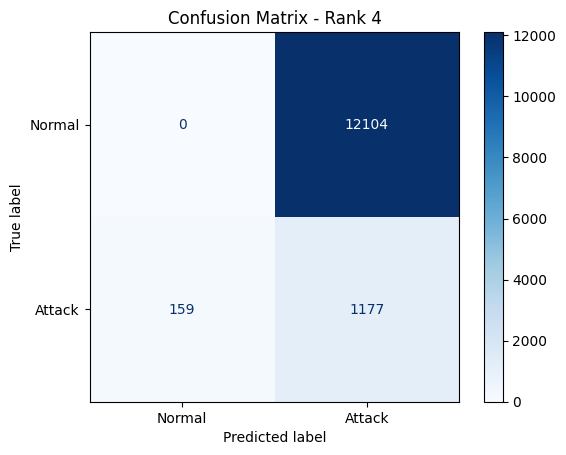

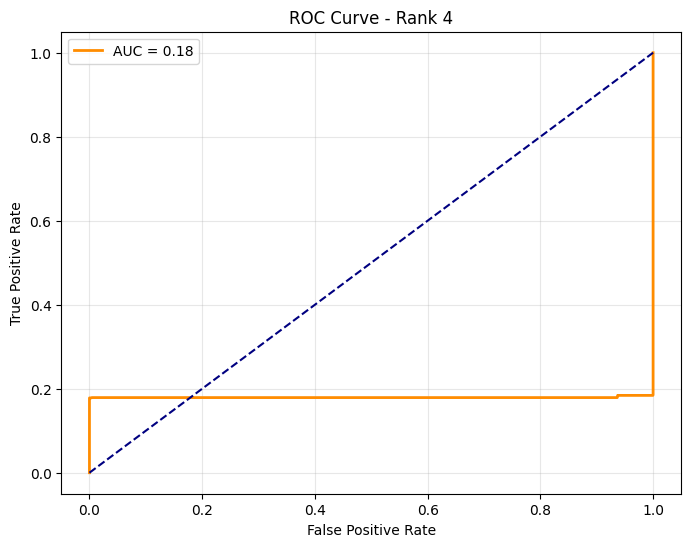

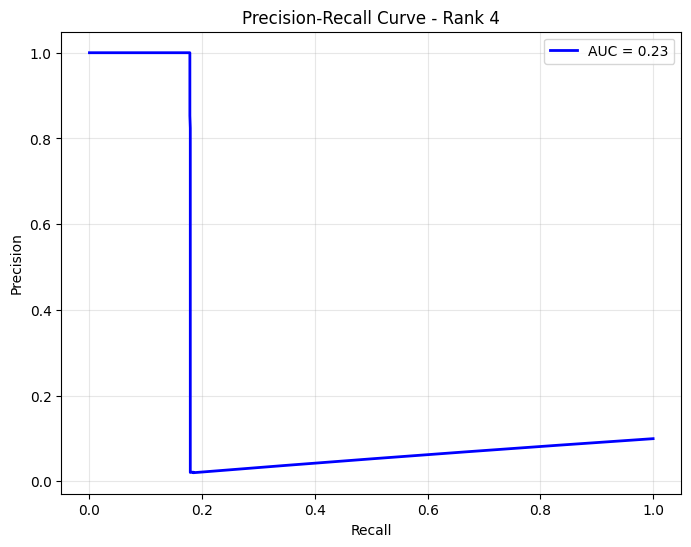


=== Rank 5 ===
error= tensor(0.0146, device='cuda:0')
error= 0.014637870714068413
✅ Projection completed.
Residual norm: 2144.044921875
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.4392 - auc_7: 0.3706 - loss: 0.9401 - val_accuracy: 0.1207 - val_auc_7: 0.6456 - val_loss: 0.7767
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5860 - auc_7: 0.6279 - loss: 0.6973 - val_accuracy: 0.9298 - val_auc_7: 0.8352 - val_loss: 0.5810
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7188 - auc_7: 0.8058 - loss: 0.5435 - val_accuracy: 0.9285 - val_auc_7: 0.9260 - val_loss: 0.4435
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8149 - auc_7: 0.8675 - loss: 0.4547 - val_accuracy: 0.9369 - val_auc_7: 0.9672 - val_loss: 0.3601
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8790 - auc_7: 0.9034 - loss: 0.3785 - val_acc

<Figure size 600x500 with 0 Axes>

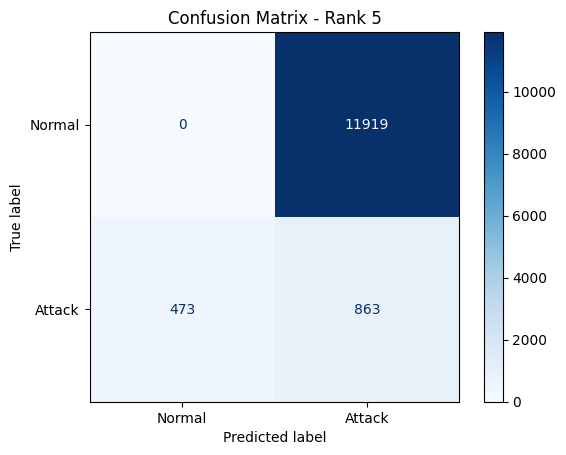

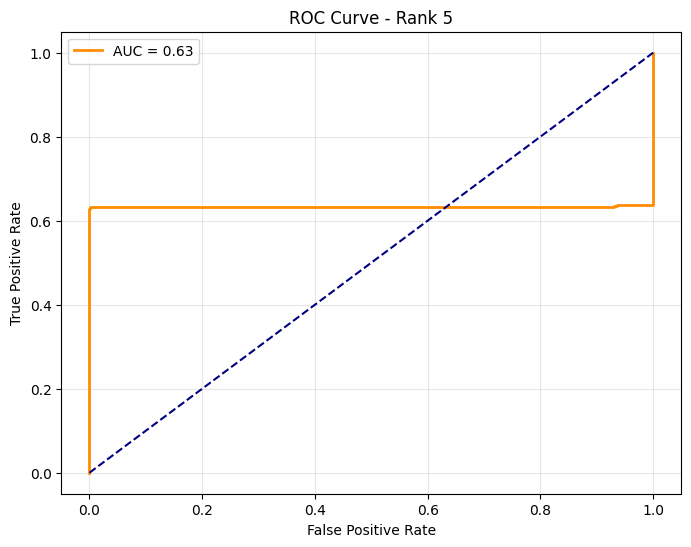

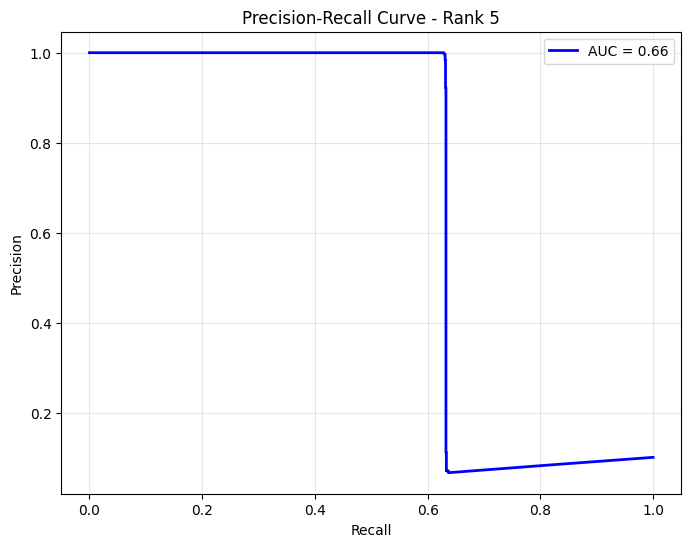


=== Rank 6 ===
error= tensor(0.0126, device='cuda:0')
error= 0.012609560042619705
✅ Projection completed.
Residual norm: 2197.984619140625
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.5515 - auc_8: 0.5886 - loss: 0.7912 - val_accuracy: 0.8918 - val_auc_8: 0.5700 - val_loss: 0.5277
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7133 - auc_8: 0.7778 - loss: 0.5741 - val_accuracy: 0.8958 - val_auc_8: 0.4537 - val_loss: 0.4504
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8422 - auc_8: 0.8689 - loss: 0.4408 - val_accuracy: 0.8991 - val_auc_8: 0.5023 - val_loss: 0.3818
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8792 - auc_8: 0.8723 - loss: 0.3768 - val_accuracy: 0.9025 - val_auc_8: 0.5587 - val_loss: 0.3586
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9026 - auc_8: 0.8828 - loss: 0.3321 - val_

<Figure size 600x500 with 0 Axes>

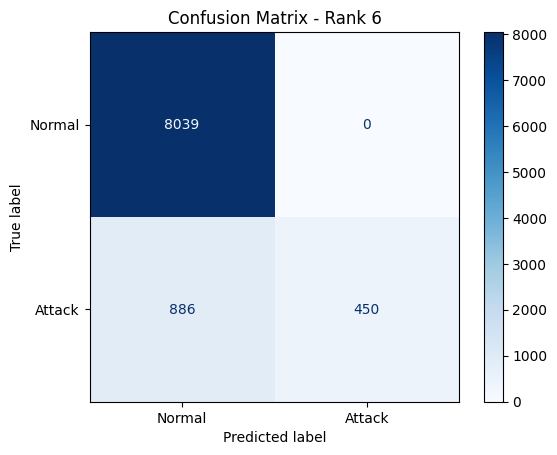

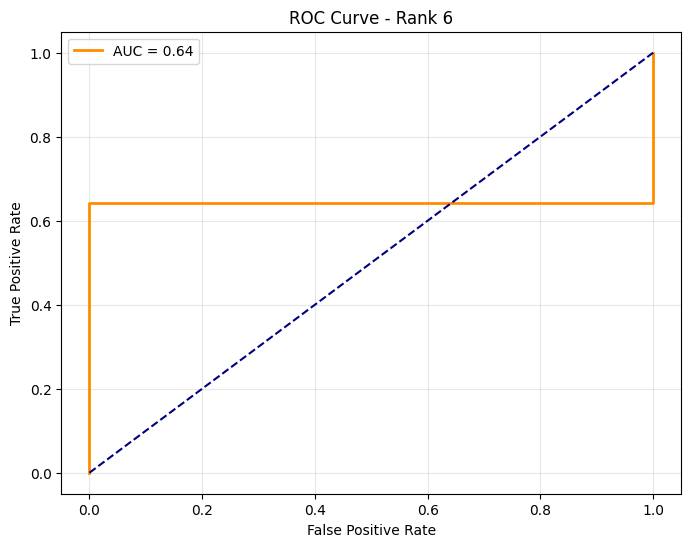

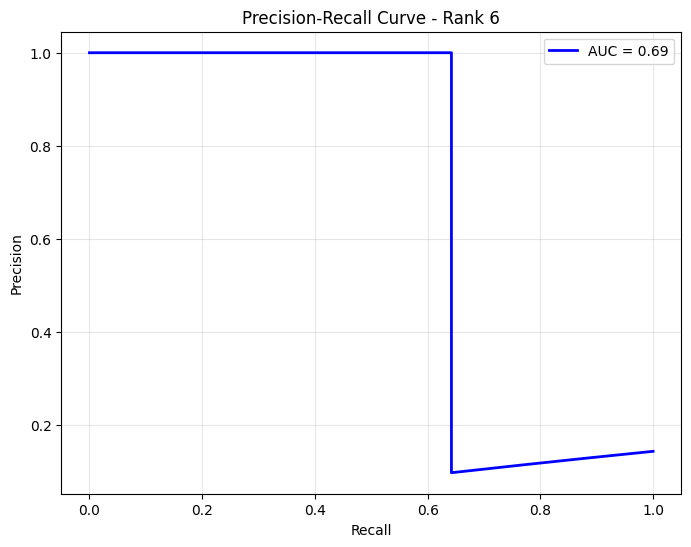


=== Rank 7 ===
error= tensor(0.0140, device='cuda:0')
error= 0.014011051505804062
✅ Projection completed.
Residual norm: 2009.626953125
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6323 - auc_9: 0.7274 - loss: 0.7057 - val_accuracy: 0.8894 - val_auc_9: 0.9312 - val_loss: 0.3965
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7778 - auc_9: 0.9040 - loss: 0.4861 - val_accuracy: 0.8980 - val_auc_9: 0.9774 - val_loss: 0.3365
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8660 - auc_9: 0.9262 - loss: 0.3941 - val_accuracy: 0.9372 - val_auc_9: 0.9785 - val_loss: 0.2993
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9111 - auc_9: 0.9354 - loss: 0.3210 - val_accuracy: 0.9413 - val_auc_9: 0.9815 - val_loss: 0.2545
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9387 - auc_9: 0.9432 - loss: 0.2694 - val_ac

<Figure size 600x500 with 0 Axes>

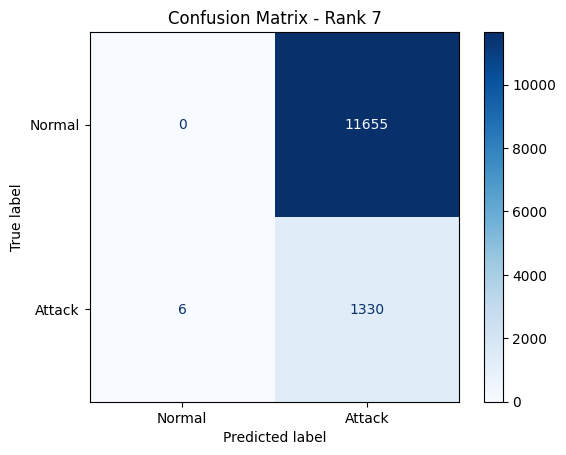

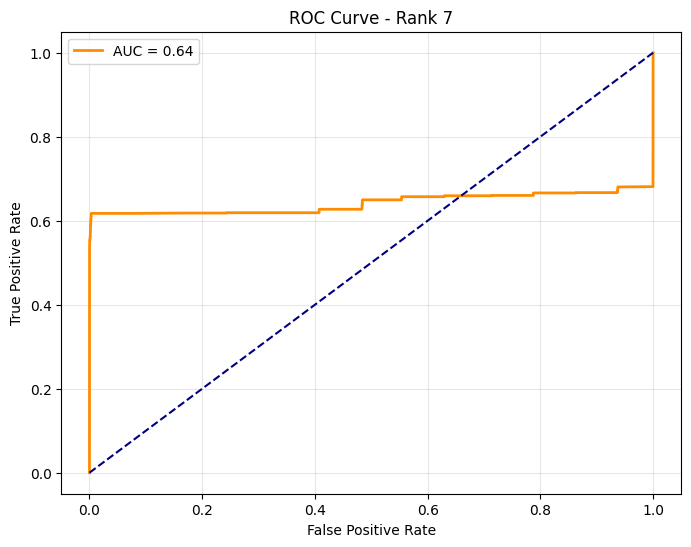

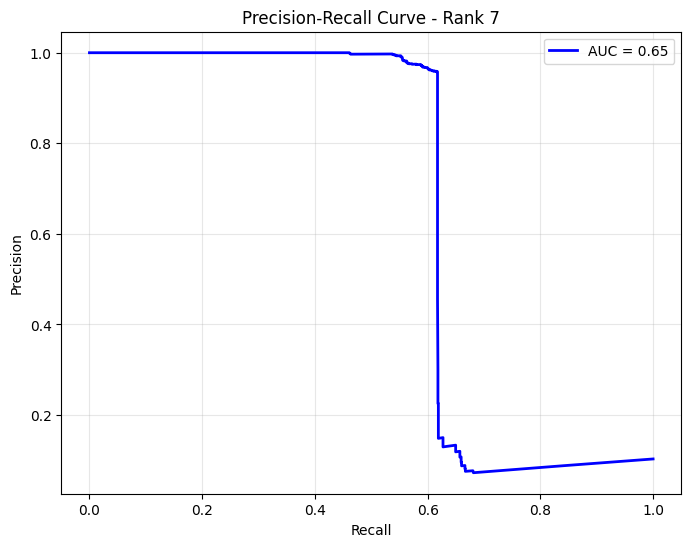


=== Rank 8 ===
error= tensor(0.0126, device='cuda:0')
error= 0.012609800323843956
✅ Projection completed.
Residual norm: 2069.369384765625
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5576 - auc_10: 0.6188 - loss: 0.7565 - val_accuracy: 0.9274 - val_auc_10: 0.9895 - val_loss: 0.5554
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7547 - auc_10: 0.8988 - loss: 0.5217 - val_accuracy: 0.9537 - val_auc_10: 0.9910 - val_loss: 0.3687
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8349 - auc_10: 0.9475 - loss: 0.4279 - val_accuracy: 0.9852 - val_auc_10: 0.9910 - val_loss: 0.2424
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9071 - auc_10: 0.9622 - loss: 0.3281 - val_accuracy: 0.9749 - val_auc_10: 0.9876 - val_loss: 0.1917
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9452 - auc_10: 0.9708 - loss: 0.2

<Figure size 600x500 with 0 Axes>

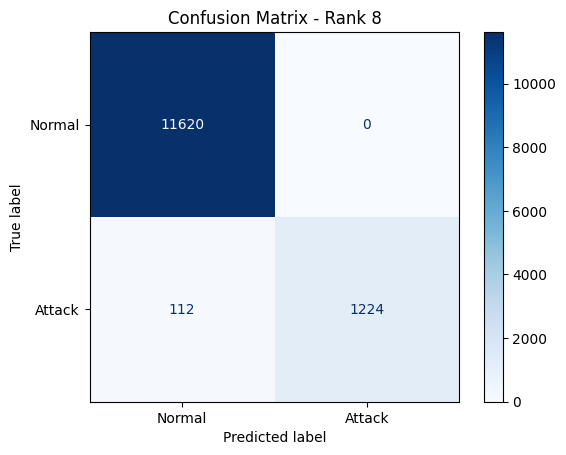

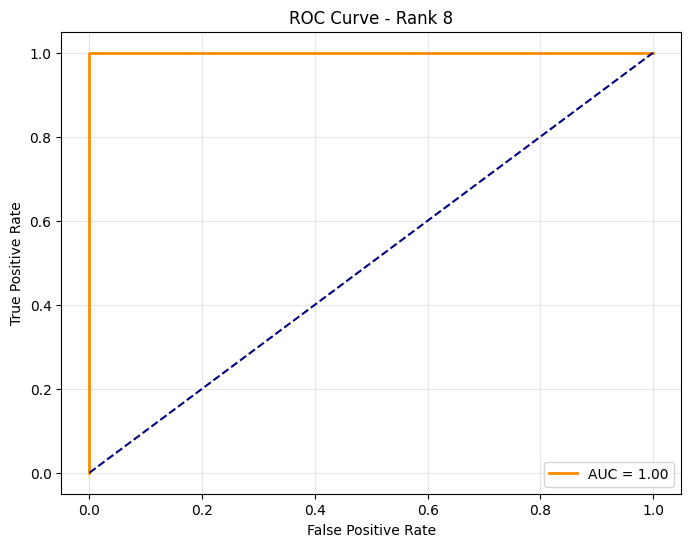

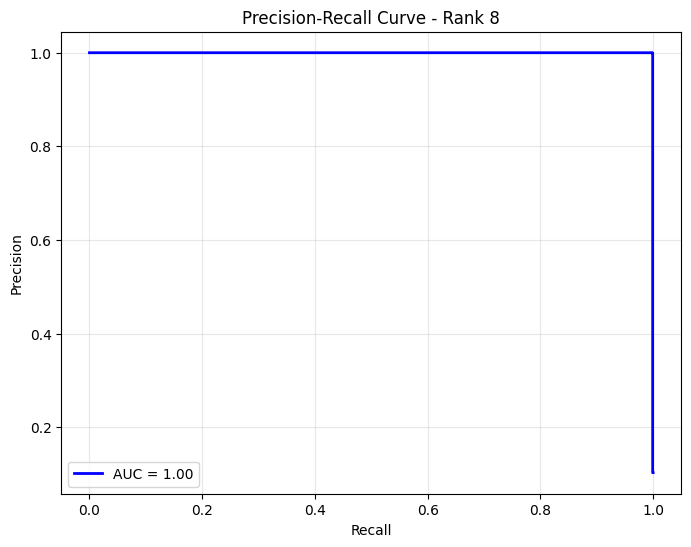


=== Rank 9 ===
error= tensor(0.0155, device='cuda:0')
error= 0.015545766800642014
✅ Projection completed.
Residual norm: 2137.66455078125
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.5218 - auc_11: 0.4942 - loss: 0.8466 - val_accuracy: 0.1151 - val_auc_11: 0.4403 - val_loss: 0.7146
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6836 - auc_11: 0.7229 - loss: 0.6132 - val_accuracy: 0.9063 - val_auc_11: 0.9516 - val_loss: 0.5044
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7872 - auc_11: 0.8122 - loss: 0.4919 - val_accuracy: 0.9090 - val_auc_11: 0.9771 - val_loss: 0.3851
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8671 - auc_11: 0.8776 - loss: 0.4007 - val_accuracy: 0.9096 - val_auc_11: 0.9695 - val_loss: 0.3453
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8989 - auc_11: 0.8979 - loss: 0.344

<Figure size 600x500 with 0 Axes>

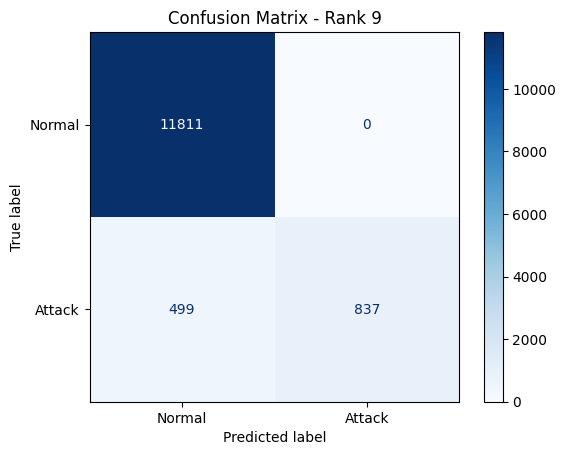

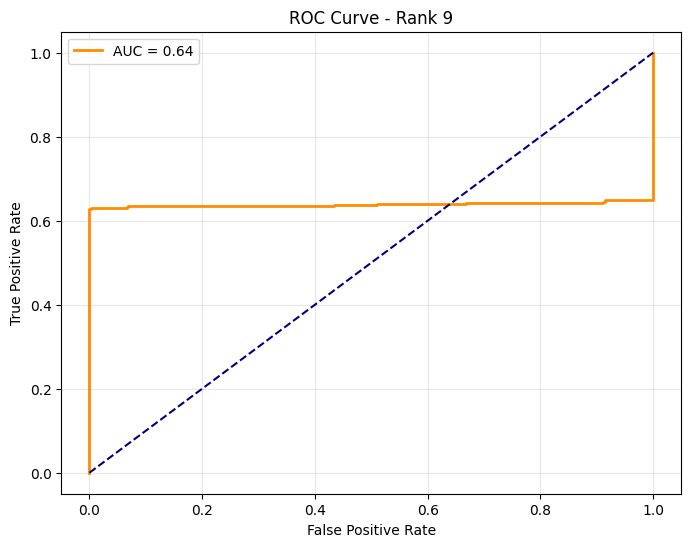

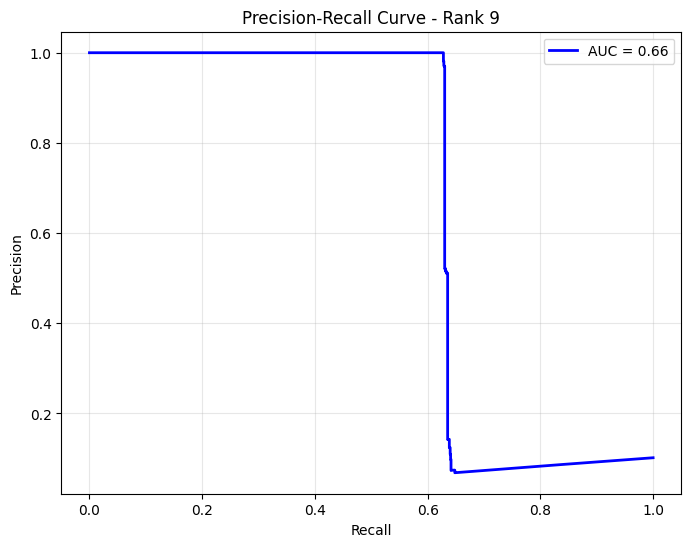


=== Rank 10 ===
error= tensor(0.0113, device='cuda:0')
error= 0.011304076761007309
✅ Projection completed.
Residual norm: 1558.579833984375
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4704 - auc_12: 0.4682 - loss: 0.8699 - val_accuracy: 0.1214 - val_auc_12: 0.8660 - val_loss: 0.8879
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6134 - auc_12: 0.7133 - loss: 0.6548 - val_accuracy: 0.1217 - val_auc_12: 0.9459 - val_loss: 0.7258
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7210 - auc_12: 0.7961 - loss: 0.5437 - val_accuracy: 0.9630 - val_auc_12: 0.9583 - val_loss: 0.5734
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7912 - auc_12: 0.8263 - loss: 0.4648 - val_accuracy: 0.9507 - val_auc_12: 0.8457 - val_loss: 0.5031
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8406 - auc_12: 0.8195 - loss: 0.41

<Figure size 600x500 with 0 Axes>

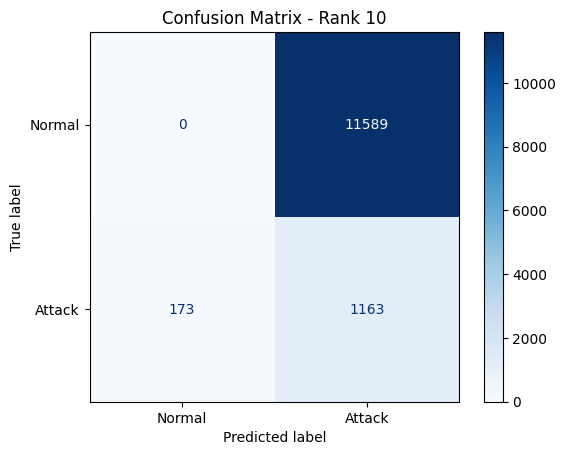

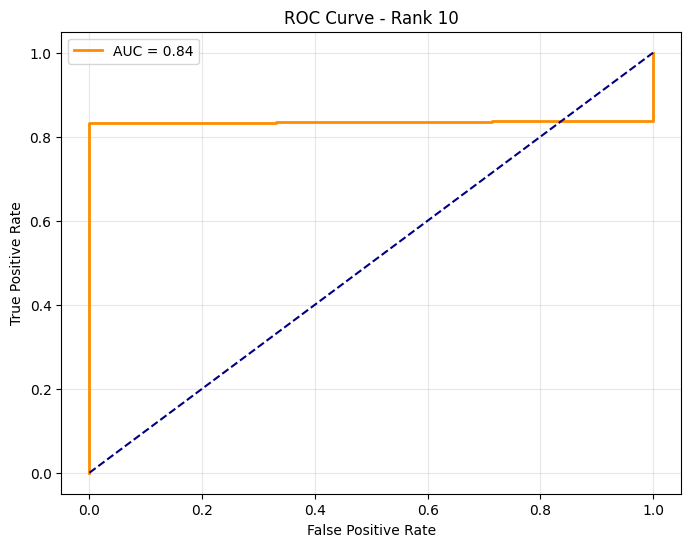

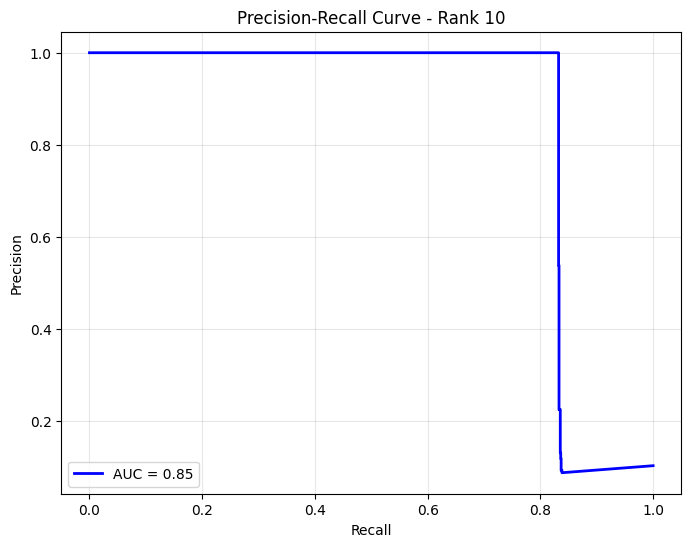


=== Rank 11 ===
error= tensor(0.0131, device='cuda:0')
error= 0.01314553339034319
✅ Projection completed.
Residual norm: 2198.147705078125
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.4554 - auc_13: 0.4531 - loss: 0.9058 - val_accuracy: 0.1333 - val_auc_13: 0.4582 - val_loss: 0.7782
Epoch 2/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6614 - auc_13: 0.7868 - loss: 0.6100 - val_accuracy: 0.9910 - val_auc_13: 0.9740 - val_loss: 0.6058
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7946 - auc_13: 0.9182 - loss: 0.4587 - val_accuracy: 0.9901 - val_auc_13: 0.9808 - val_loss: 0.4630
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8529 - auc_13: 0.9433 - loss: 0.3918 - val_accuracy: 0.9871 - val_auc_13: 0.9882 - val_loss: 0.3873
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9152 - auc_13: 0.9748 - loss: 0.31

<Figure size 600x500 with 0 Axes>

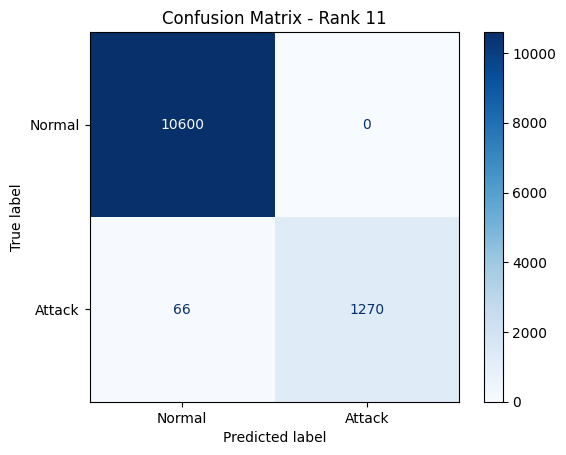

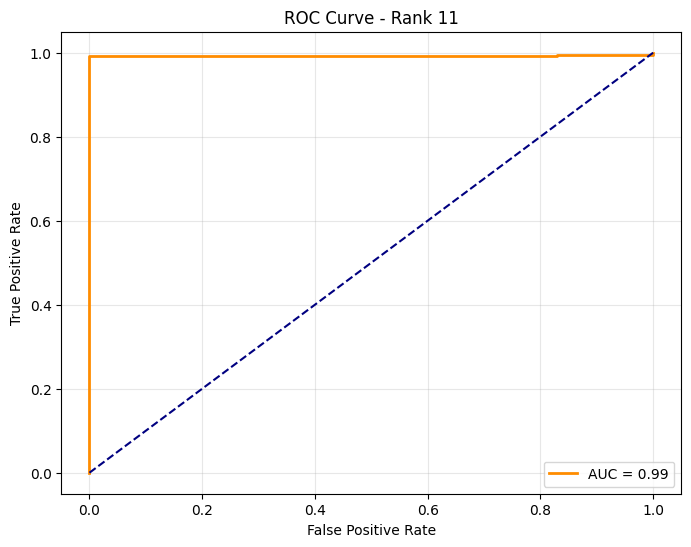

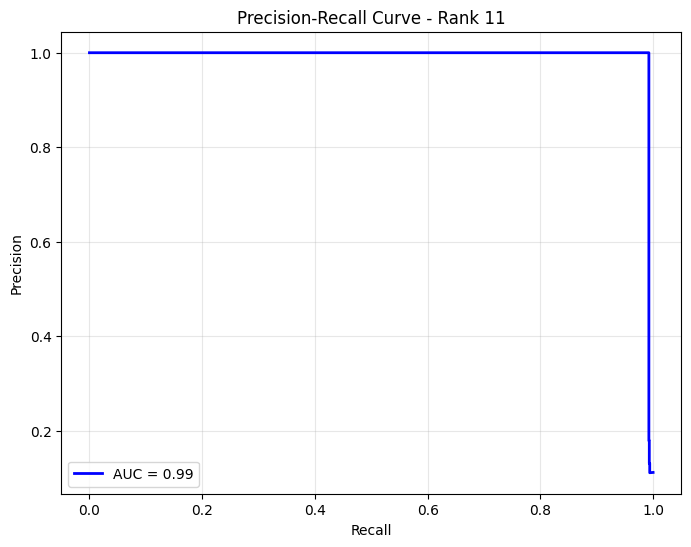


=== Rank 12 ===
error= tensor(0.0117, device='cuda:0')
error= 0.011658773757517338
✅ Projection completed.
Residual norm: 2195.023193359375
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5905 - auc_14: 0.6642 - loss: 0.7437 - val_accuracy: 0.9188 - val_auc_14: 0.7880 - val_loss: 0.4654
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7955 - auc_14: 0.9070 - loss: 0.4919 - val_accuracy: 0.9497 - val_auc_14: 0.9827 - val_loss: 0.3479
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8838 - auc_14: 0.9188 - loss: 0.3935 - val_accuracy: 0.9466 - val_auc_14: 0.9903 - val_loss: 0.2789
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9302 - auc_14: 0.9509 - loss: 0.3168 - val_accuracy: 0.9492 - val_auc_14: 0.9908 - val_loss: 0.2363
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9500 - auc_14: 0.9507 - loss: 0.

<Figure size 600x500 with 0 Axes>

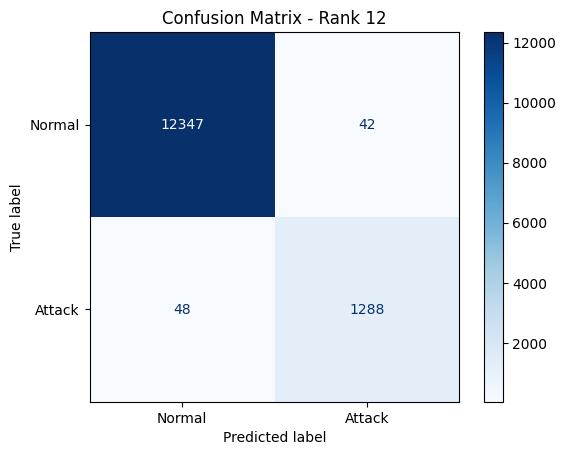

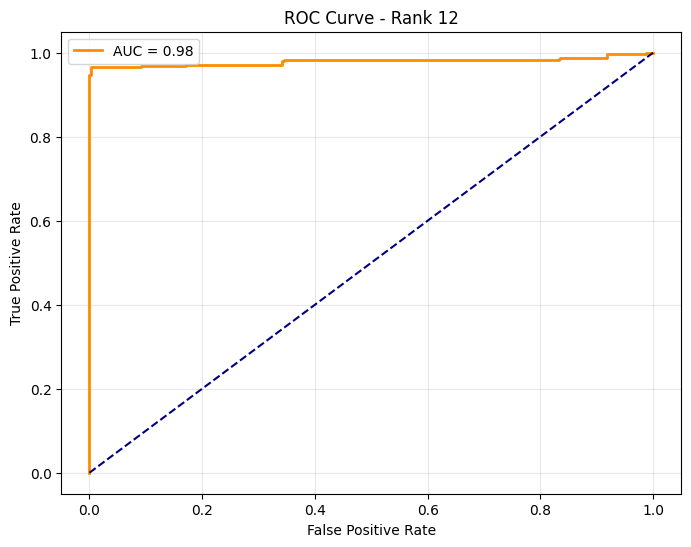

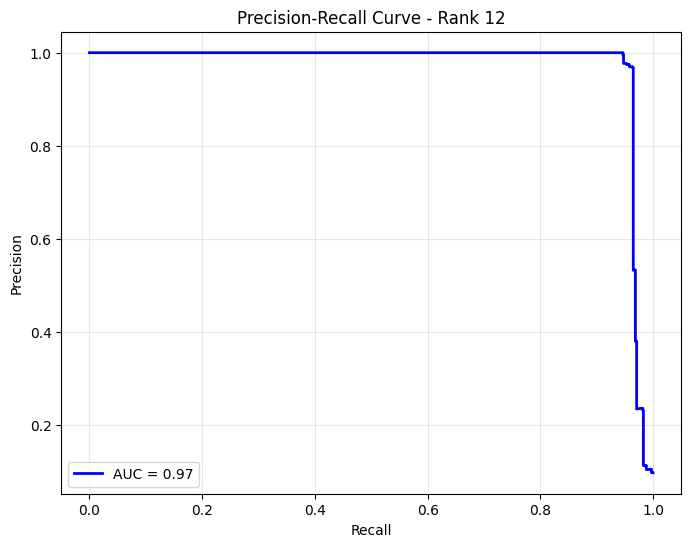


=== Rank 13 ===
error= tensor(0.0117, device='cuda:0')
error= 0.011694138869643211
✅ Projection completed.
Residual norm: 2146.8232421875
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.6784 - auc_15: 0.7494 - loss: 0.6656 - val_accuracy: 0.8900 - val_auc_15: 0.5384 - val_loss: 0.3803
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.7502 - auc_15: 0.7614 - loss: 0.5576 - val_accuracy: 0.8979 - val_auc_15: 0.6274 - val_loss: 0.3565
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8086 - auc_15: 0.7603 - loss: 0.4908 - val_accuracy: 0.9041 - val_auc_15: 0.6752 - val_loss: 0.3258
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8649 - auc_15: 0.7795 - loss: 0.4171 - val_accuracy: 0.9046 - val_auc_15: 0.6577 - val_loss: 0.3219
Epoch 5/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8694 - auc_15: 0.7853 - loss: 0.38

<Figure size 600x500 with 0 Axes>

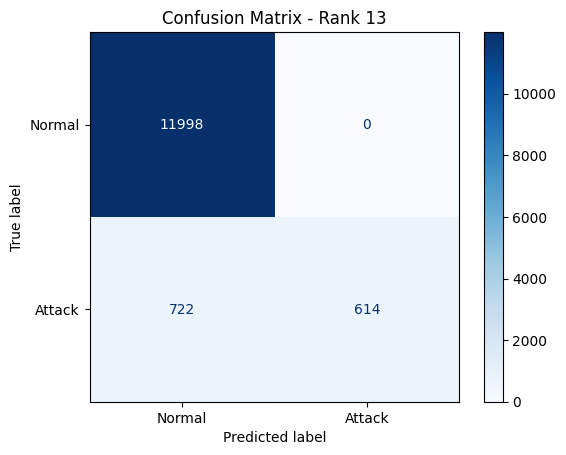

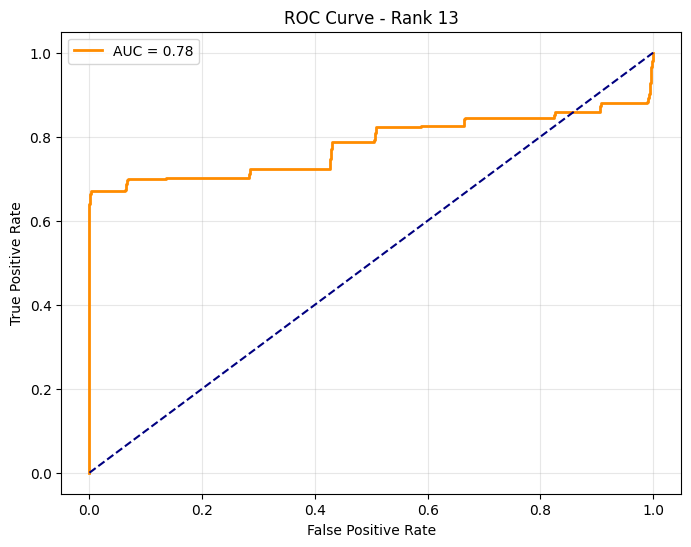

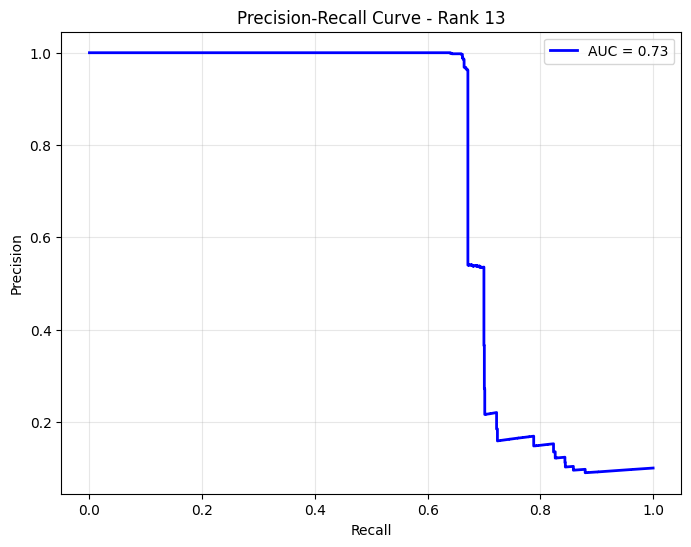


=== Rank 14 ===
error= tensor(0.0119, device='cuda:0')
error= 0.011926772072911263
✅ Projection completed.
Residual norm: 2174.918212890625
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.6173 - auc_16: 0.6744 - loss: 0.7460 - val_accuracy: 0.8899 - val_auc_16: 0.6163 - val_loss: 0.3684
Epoch 2/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7635 - auc_16: 0.8737 - loss: 0.5240 - val_accuracy: 0.8971 - val_auc_16: 0.9526 - val_loss: 0.3207
Epoch 3/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8486 - auc_16: 0.9019 - loss: 0.4155 - val_accuracy: 0.9067 - val_auc_16: 0.9740 - val_loss: 0.2768
Epoch 4/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9011 - auc_16: 0.9398 - loss: 0.3322 - val_accuracy: 0.9095 - val_auc_16: 0.9549 - val_loss: 0.2678
Epoch 5/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9361 - auc_16: 0.9504 - loss: 0.

<Figure size 600x500 with 0 Axes>

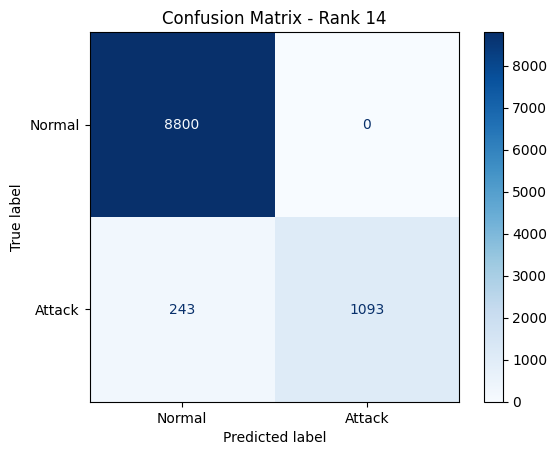

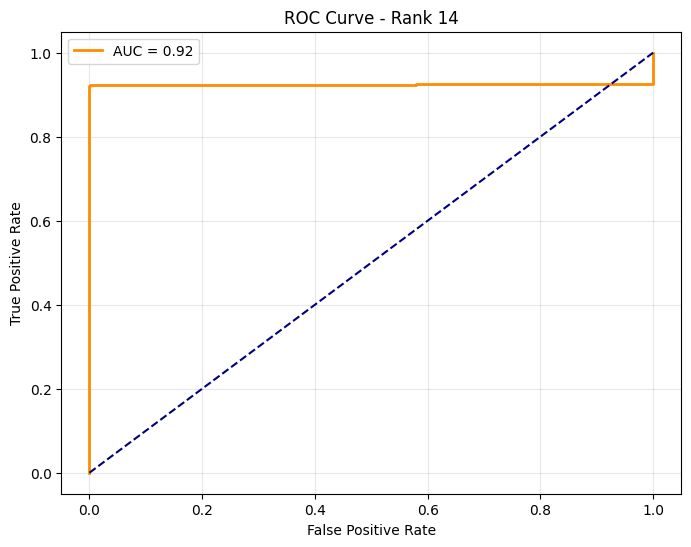

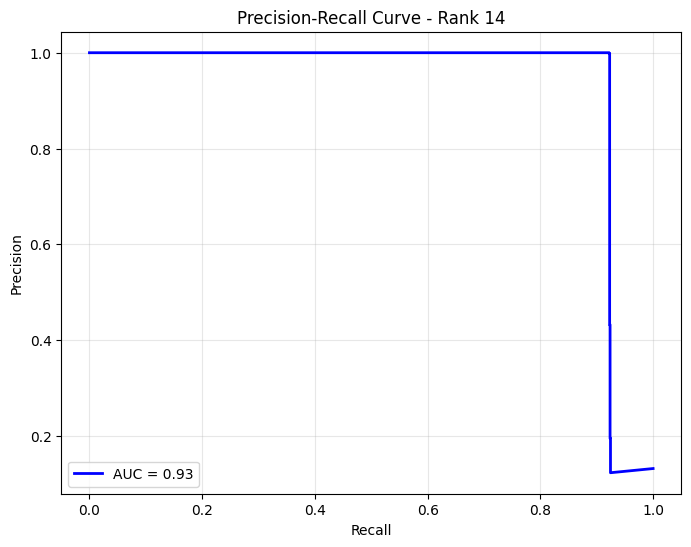


=== Rank 15 ===
error= tensor(0.0117, device='cuda:0')
error= 0.011712727136909962
✅ Projection completed.
Residual norm: 2186.69970703125
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.5950 - auc_17: 0.6370 - loss: 0.7560 - val_accuracy: 0.8911 - val_auc_17: 0.9379 - val_loss: 0.4479
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7395 - auc_17: 0.8144 - loss: 0.5510 - val_accuracy: 0.8975 - val_auc_17: 0.9815 - val_loss: 0.3493
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8315 - auc_17: 0.8644 - loss: 0.4500 - val_accuracy: 0.8919 - val_auc_17: 0.9763 - val_loss: 0.3189
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8745 - auc_17: 0.8752 - loss: 0.3929 - val_accuracy: 0.8984 - val_auc_17: 0.9887 - val_loss: 0.2877
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9146 - auc_17: 0.9071 - loss: 0.32

<Figure size 600x500 with 0 Axes>

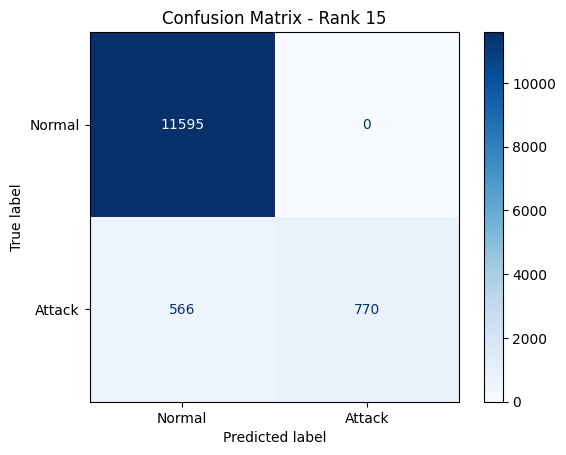

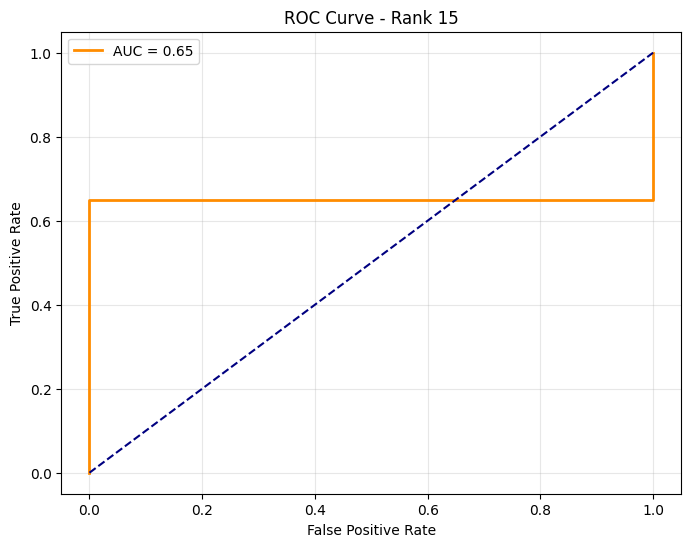

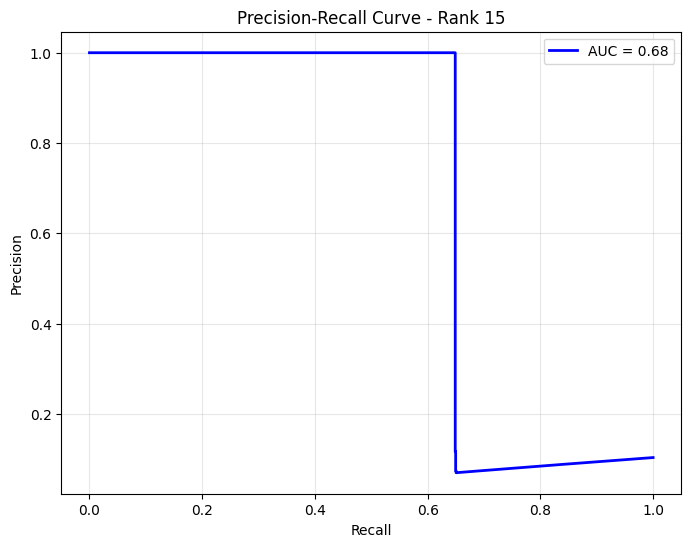


=== Rank 16 ===
error= tensor(0.0151, device='cuda:0')
error= 0.015066862106323242
✅ Projection completed.
Residual norm: 1903.938232421875
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.6444 - auc_18: 0.7604 - loss: 0.6938 - val_accuracy: 0.8913 - val_auc_18: 0.8325 - val_loss: 0.3757
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7533 - auc_18: 0.8193 - loss: 0.5374 - val_accuracy: 0.8999 - val_auc_18: 0.9926 - val_loss: 0.3396
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8043 - auc_18: 0.8249 - loss: 0.4622 - val_accuracy: 0.9060 - val_auc_18: 0.7400 - val_loss: 0.3397
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8527 - auc_18: 0.8225 - loss: 0.4016 - val_accuracy: 0.9038 - val_auc_18: 0.6501 - val_loss: 0.3141
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8866 - auc_18: 0.8551 - loss: 0.3

<Figure size 600x500 with 0 Axes>

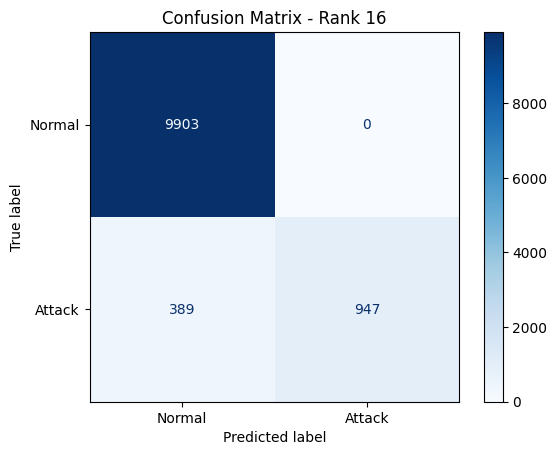

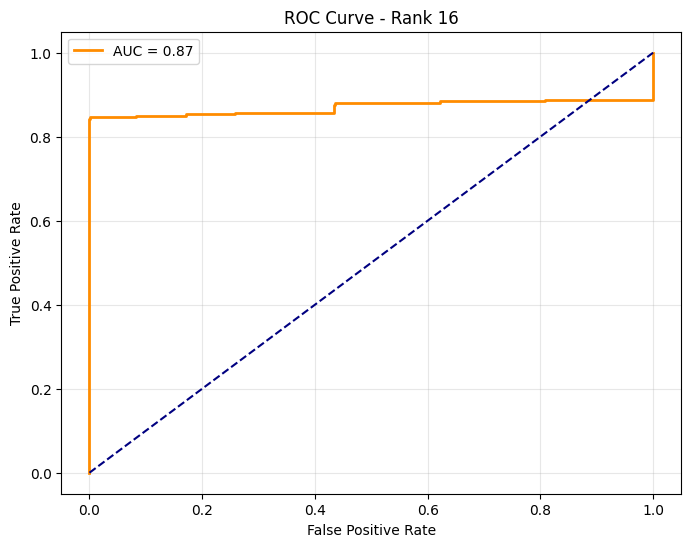

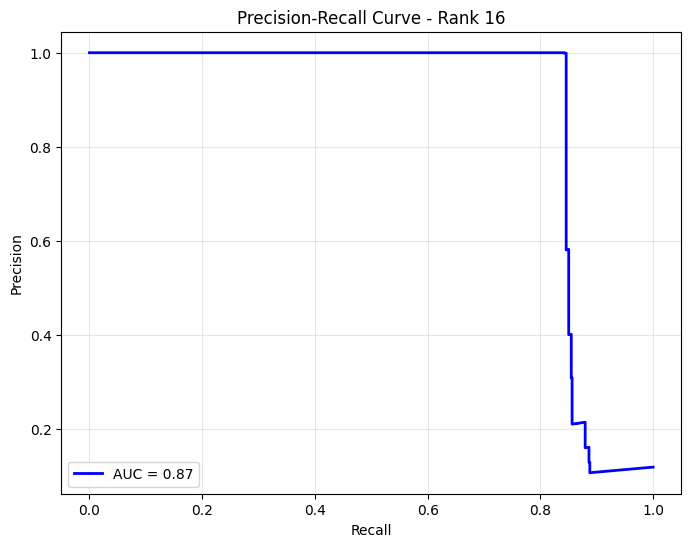


=== Rank 17 ===
error= tensor(0.0329, device='cuda:0')
error= 0.032871052622795105
✅ Projection completed.
Residual norm: 2176.93994140625
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5296 - auc_19: 0.5086 - loss: 0.8525 - val_accuracy: 0.8938 - val_auc_19: 0.6321 - val_loss: 0.4517
Epoch 2/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6956 - auc_19: 0.7475 - loss: 0.6019 - val_accuracy: 0.9098 - val_auc_19: 0.7009 - val_loss: 0.3658
Epoch 3/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8036 - auc_19: 0.8225 - loss: 0.4709 - val_accuracy: 0.9184 - val_auc_19: 0.7607 - val_loss: 0.3204
Epoch 4/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8565 - auc_19: 0.8525 - loss: 0.3960 - val_accuracy: 0.9170 - val_auc_19: 0.7686 - val_loss: 0.3153
Epoch 5/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8870 - auc_19: 0.8603 - loss: 0.34

<Figure size 600x500 with 0 Axes>

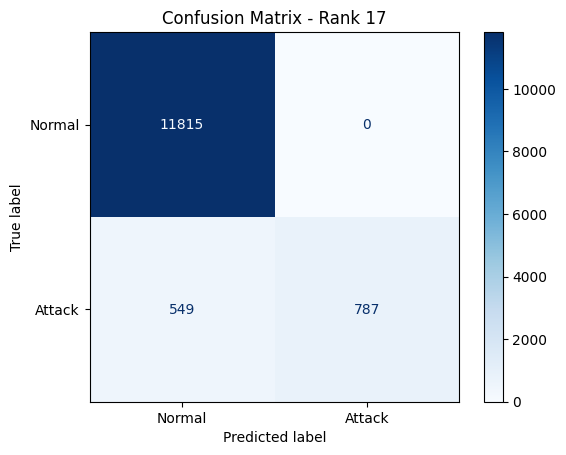

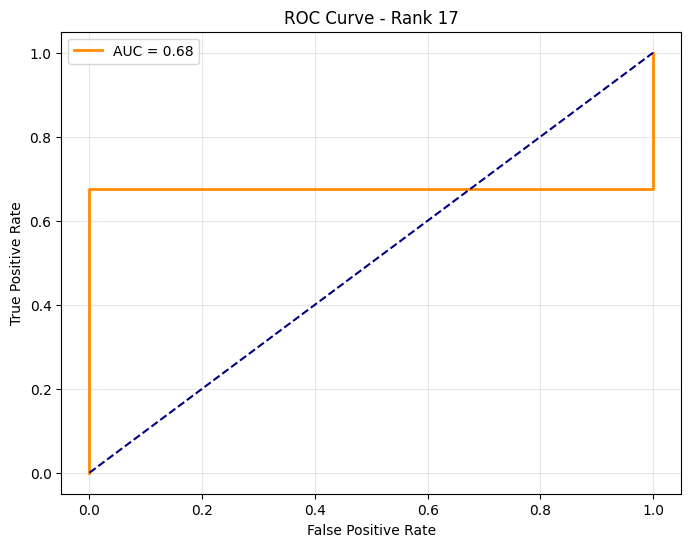

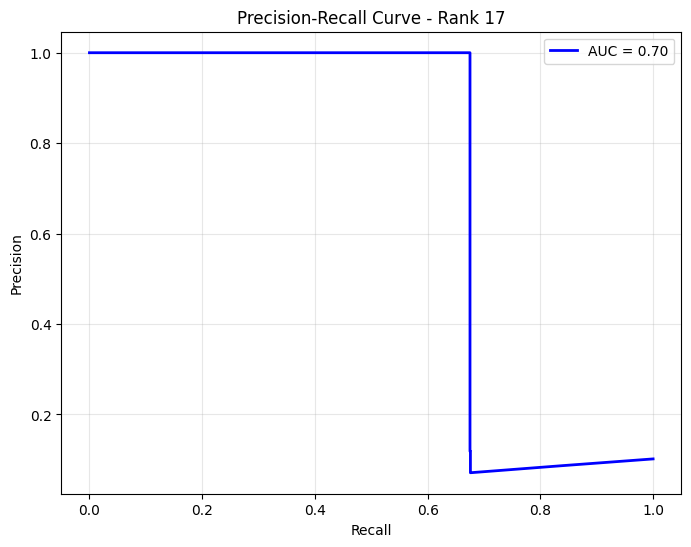


=== Rank 18 ===
error= tensor(0.0330, device='cuda:0')
error= 0.03297298029065132
✅ Projection completed.
Residual norm: 752.018798828125
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.4266 - auc_20: 0.3765 - loss: 1.0245 - val_accuracy: 0.1191 - val_auc_20: 0.7269 - val_loss: 0.9306
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5772 - auc_20: 0.6187 - loss: 0.7174 - val_accuracy: 0.9552 - val_auc_20: 0.8533 - val_loss: 0.6720
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6766 - auc_20: 0.7247 - loss: 0.5912 - val_accuracy: 0.9453 - val_auc_20: 0.9086 - val_loss: 0.5787
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7764 - auc_20: 0.8016 - loss: 0.4907 - val_accuracy: 0.9254 - val_auc_20: 0.9176 - val_loss: 0.4545
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8227 - auc_20: 0.8270 - loss: 0.43

<Figure size 600x500 with 0 Axes>

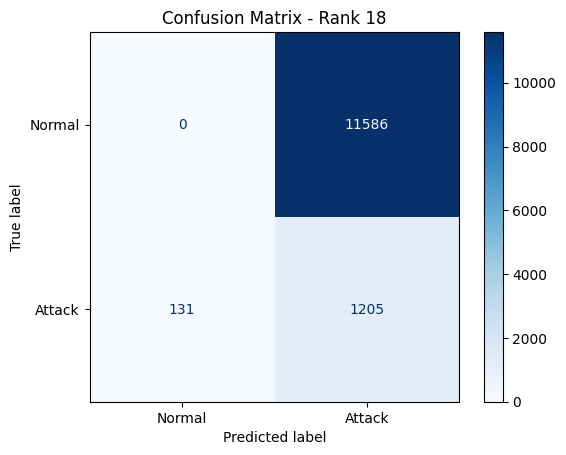

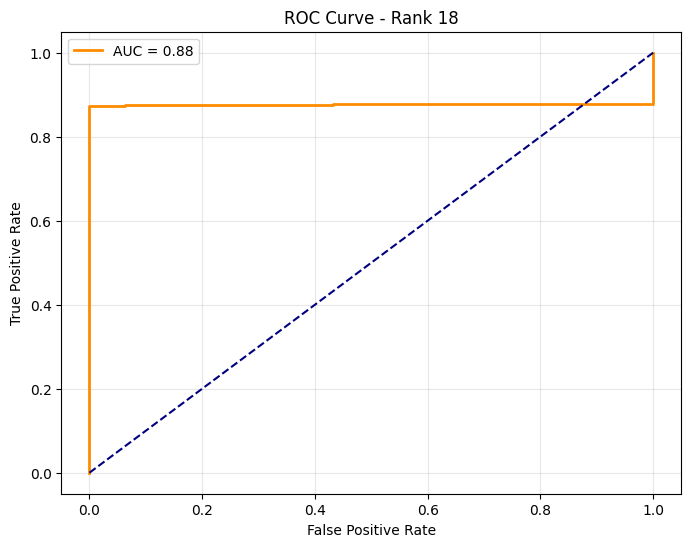

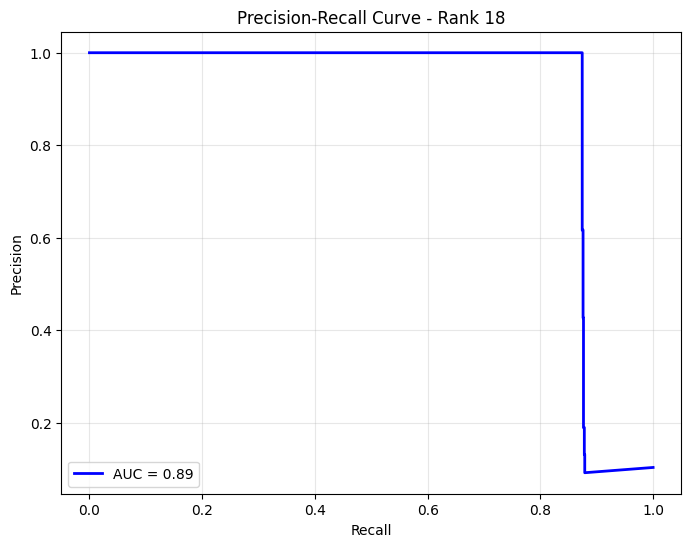


=== Rank 19 ===
error= tensor(0.0132, device='cuda:0')
error= 0.013236324302852154
✅ Projection completed.
Residual norm: 1776.1025390625
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5438 - auc_21: 0.6014 - loss: 0.8434 - val_accuracy: 0.8898 - val_auc_21: 0.7540 - val_loss: 0.5203
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6710 - auc_21: 0.7438 - loss: 0.6277 - val_accuracy: 0.9041 - val_auc_21: 0.8499 - val_loss: 0.3739
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7445 - auc_21: 0.7788 - loss: 0.5396 - val_accuracy: 0.9257 - val_auc_21: 0.9571 - val_loss: 0.2933
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8334 - auc_21: 0.8154 - loss: 0.4336 - val_accuracy: 0.9237 - val_auc_21: 0.9323 - val_loss: 0.2765
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8463 - auc_21: 0.8014 - loss: 0.406

<Figure size 600x500 with 0 Axes>

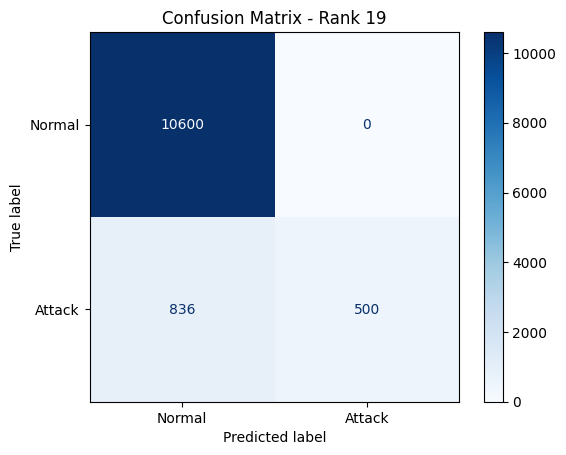

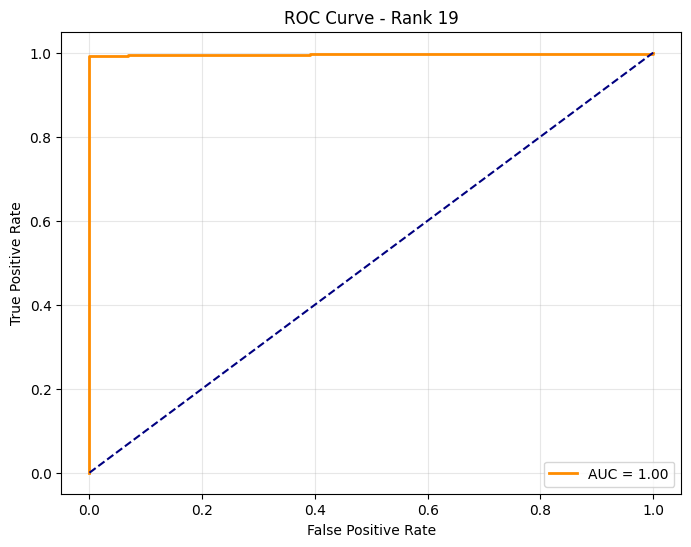

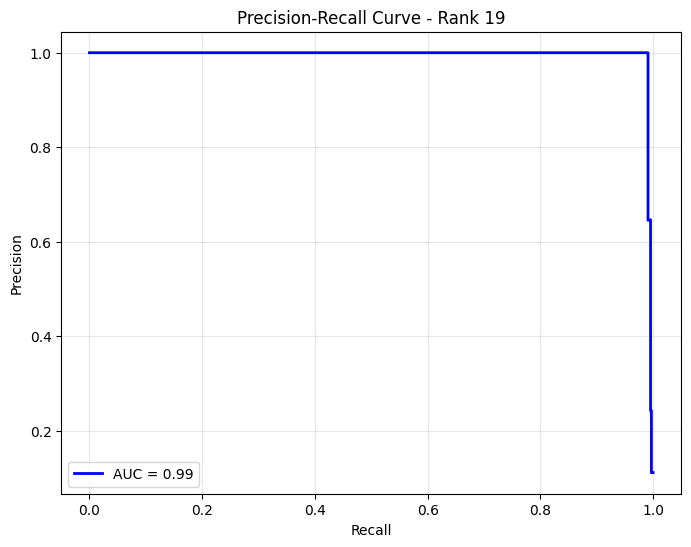


=== Rank 20 ===
error= tensor(0.0102, device='cuda:0')
error= 0.010183142498135567
✅ Projection completed.
Residual norm: 1548.7359619140625
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
Epoch 1/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.6382 - auc_22: 0.7503 - loss: 0.6902 - val_accuracy: 0.8915 - val_auc_22: 0.8307 - val_loss: 0.4283
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7666 - auc_22: 0.8171 - loss: 0.5121 - val_accuracy: 0.8988 - val_auc_22: 0.8871 - val_loss: 0.3702
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8328 - auc_22: 0.8452 - loss: 0.4381 - val_accuracy: 0.9061 - val_auc_22: 0.9447 - val_loss: 0.3543
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8787 - auc_22: 0.8640 - loss: 0.3698 - val_accuracy: 0.9105 - val_auc_22: 0.9560 - val_loss: 0.3106
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9065 - auc_22: 0.8697 - loss: 0.

<Figure size 600x500 with 0 Axes>

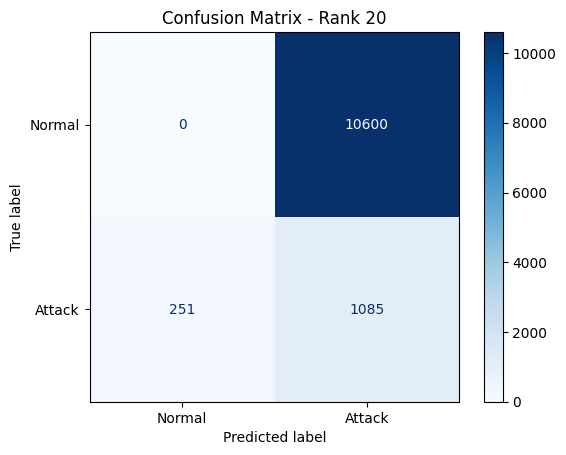

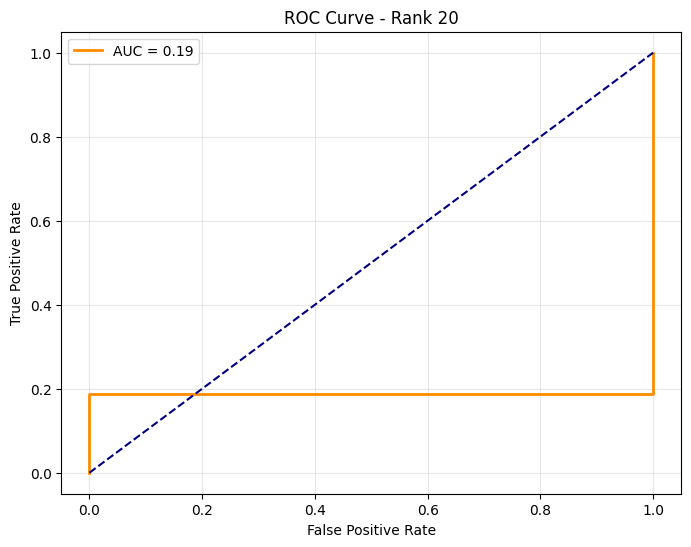

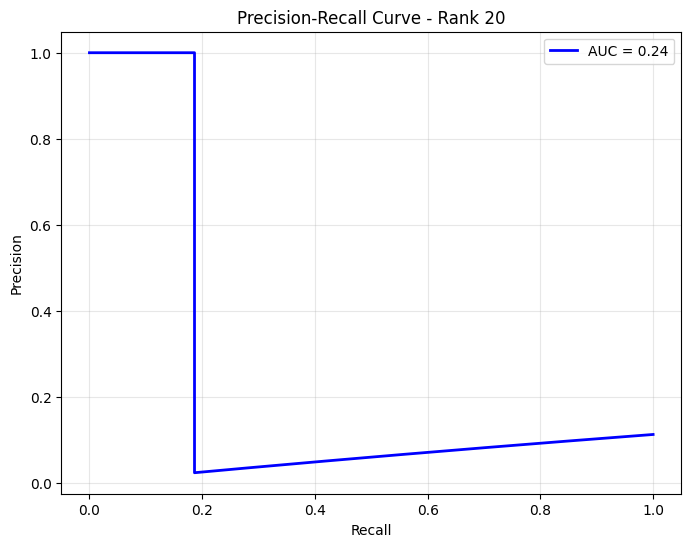

In [ ]:
# Initialize lists
error_list = []
cm_list = []
model_results = []
model_list = []
df_test_list = []

# Loop over CP ranks from 1 to 20
for rank in range(1, 21):
    print(f"\n=== Rank {rank} ===")

    # 1. Tensor Normal Decomposition
    factors_normal, error = Tensor_decomposition(tensor_normal, rank)
    error_list.append(error)

    # 2. Residuals on Training Tensor
    residuals_train = normal_space_projection(tensor_train, factors_normal)

    # 3. Score Aggregation (Train)
    df_scores_train = aggregation_scoring_Source(residuals_train, mappings, df_train, window_size=300)

    # 4. Outlier Removal (Train)
    df = remove_outliers_iqr(df_scores_train[df_scores_train['label']==0], features)
    df_train_cleaned = pd.concat([df,df_scores_train[df_scores_train['label']==1]],axis=0)

    # 5. Feature Extraction and Scaling
    s = StandardScaler()
    X1 = s.fit_transform(df_train_cleaned.drop(columns=['label', 'Dst IP', 'time_windows']))
    Y1 = df_train_cleaned['label']

    # 6. Train/Test Split and Model Training
    X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3, random_state=42,stratify=Y1)
    model, history = build_and_train_binary_classifier(
        X_train, y_train, X_test, y_test,
        learning_rate=0.0001, batch_size=32, epochs=50
    )
    model_list.append(model)

    # 7. Residuals on Test Tensor
    residuals_test = normal_space_projection(tensor_test, factors_normal)
    df_scores_test = aggregation_scoring_Source(residuals_test, mappings, df_test, window_size=300)
    df_test_list.append(df_scores_test)
    # 8. Outlier Removal (Test)
    df1 = remove_outliers_iqr(df_scores_test[df_scores_test['label']==0], features)
    df_test_cleaned = pd.concat([df1,df_scores_test[df_scores_test['label']==1]],axis=0)

    # 9. Feature Scaling (Use fitted scaler from train)

    X = s.transform(df_test_cleaned.drop(columns=['label', 'Dst IP', 'time_windows']))
    Y = df_test_cleaned['label']

    # 10. Prediction
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # 11. Evaluation Metrics
    accuracy = accuracy_score(Y, y_pred)
    precision = precision_score(Y, y_pred)
    recall = recall_score(Y, y_pred)
    f1 = f1_score(Y, y_pred)

    model_results.append({
        'Model': f'Model_{rank}',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    })

    # 12. Confusion Matrix
    cm = confusion_matrix(Y, y_pred)
    cm_list.append(cm)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - Rank {rank}')
    plt.show()

    # 13. ROC Curve
    fpr, tpr, _ = roc_curve(Y, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Rank {rank}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 14. Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(Y, y_pred_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - Rank {rank}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


Model Comparison Results:
       Model  Accuracy  Precision  Recall  F1_Score
0    Model_1    0.2886     0.1061  0.9723    0.1914
1    Model_2    0.5457     0.1474  0.9117    0.2537
2    Model_3    0.9938     1.0000  0.9469    0.9727
3    Model_4    0.0876     0.0886  0.8810    0.1610
4    Model_5    0.0651     0.0675  0.6460    0.1223
5    Model_6    0.9055     1.0000  0.3368    0.5039
6    Model_7    0.1024     0.1024  0.9955    0.1857
7    Model_8    0.9914     1.0000  0.9162    0.9562
8    Model_9    0.9620     1.0000  0.6265    0.7704
9   Model_10    0.0900     0.0912  0.8705    0.1651
10  Model_11    0.9945     1.0000  0.9506    0.9747
11  Model_12    0.9934     0.9684  0.9641    0.9662
12  Model_13    0.9459     1.0000  0.4596    0.6297
13  Model_14    0.9760     1.0000  0.8181    0.9000
14  Model_15    0.9562     1.0000  0.5763    0.7312
15  Model_16    0.9654     1.0000  0.7088    0.8296
16  Model_17    0.9583     1.0000  0.5891    0.7414
17  Model_18    0.0933     0.0942  0.9

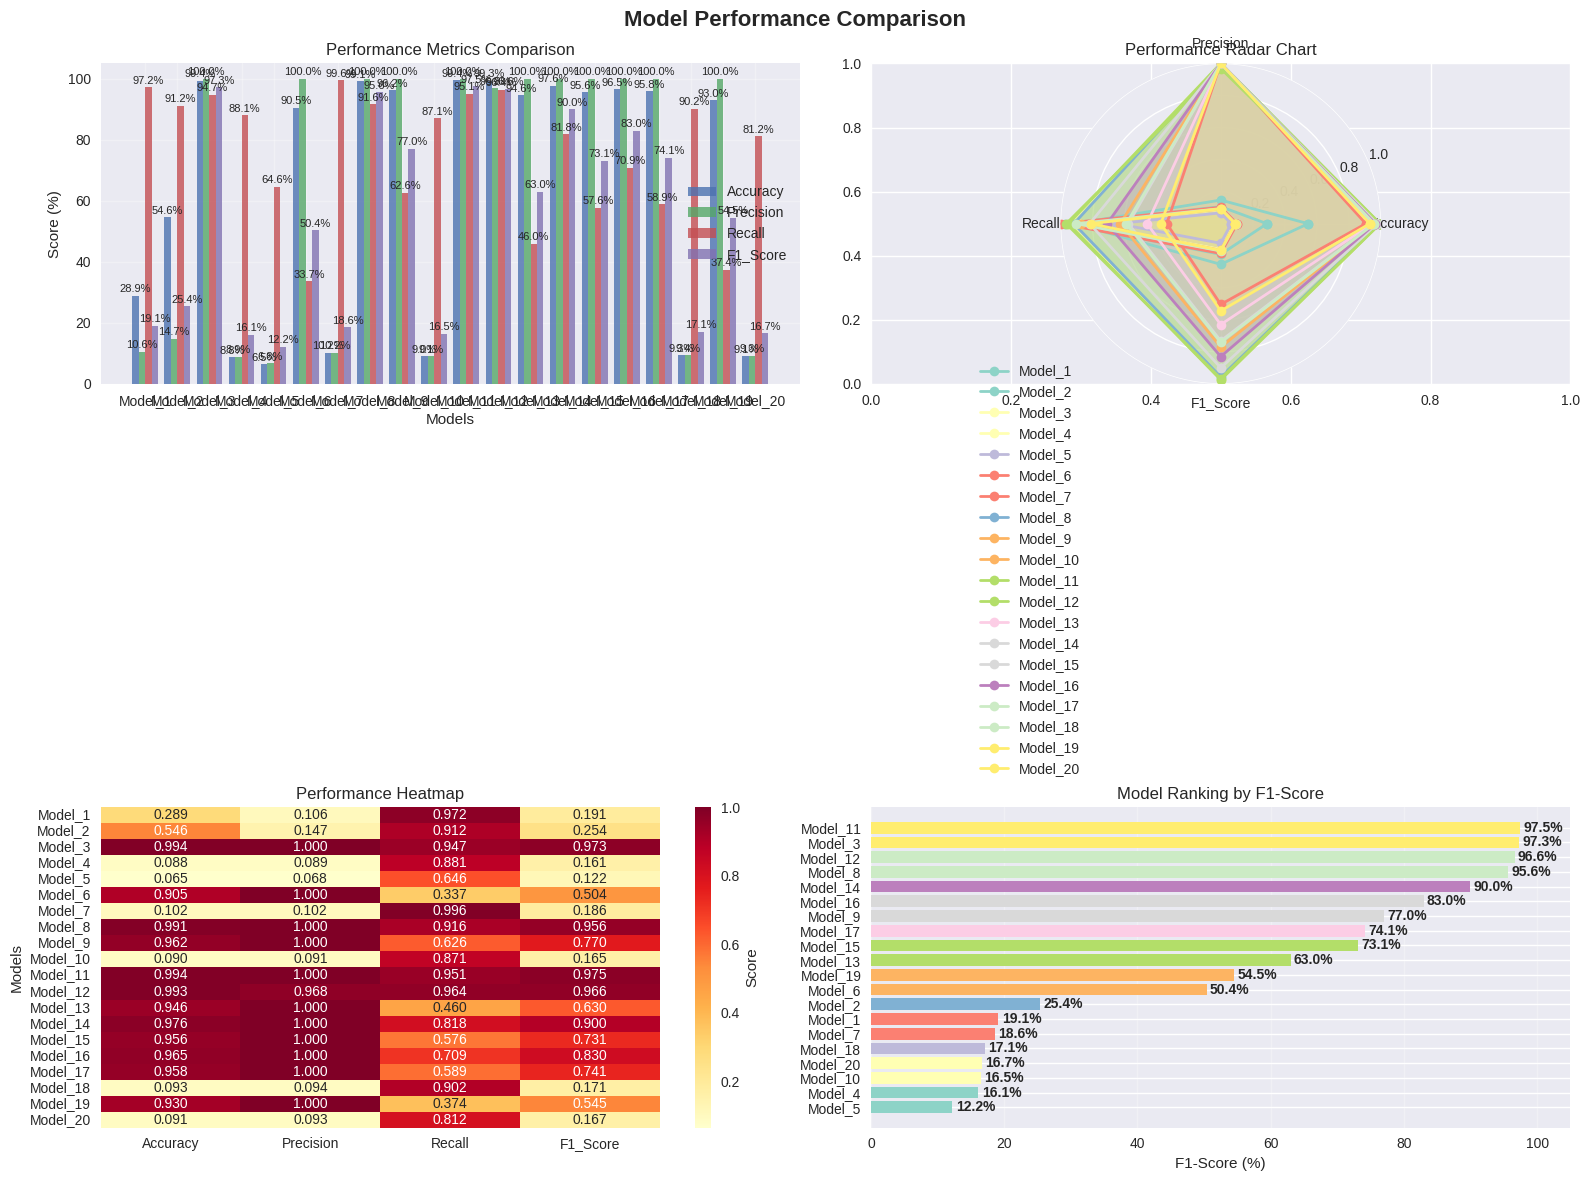

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


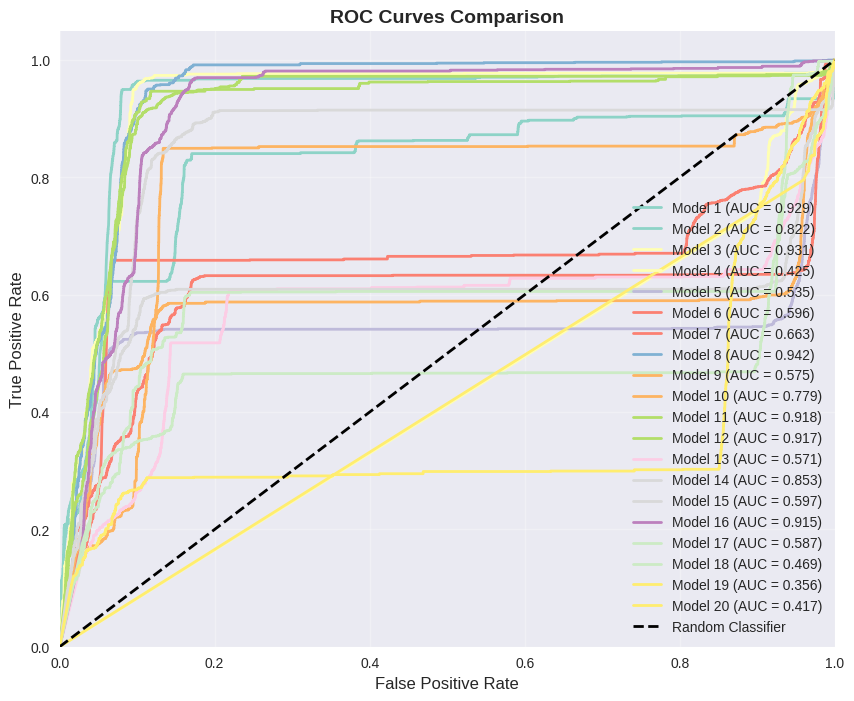

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


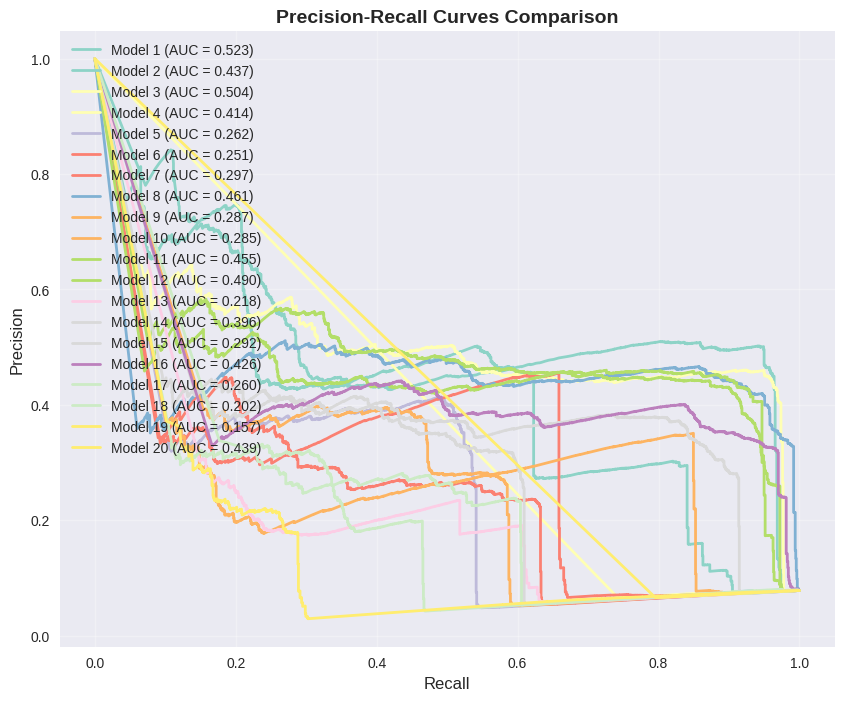


FINAL PERFORMANCE SUMMARY
   Model Accuracy Precision Recall F1_Score
 Model_1   28.86%    10.61% 97.23%   19.14%
 Model_2   54.57%    14.74% 91.17%   25.37%
 Model_3   99.38%    100.0% 94.69%   97.27%
 Model_4    8.76%     8.86%  88.1%    16.1%
 Model_5    6.51%     6.75%  64.6%   12.23%
 Model_6   90.55%    100.0% 33.68%   50.39%
 Model_7   10.24%    10.24% 99.55%   18.57%
 Model_8   99.14%    100.0% 91.62%   95.62%
 Model_9    96.2%    100.0% 62.65%   77.04%
Model_10     9.0%     9.12% 87.05%   16.51%
Model_11   99.45%    100.0% 95.06%   97.47%
Model_12   99.34%    96.84% 96.41%   96.62%
Model_13   94.59%    100.0% 45.96%   62.97%
Model_14    97.6%    100.0% 81.81%    90.0%
Model_15   95.62%    100.0% 57.63%   73.12%
Model_16   96.54%    100.0% 70.88%   82.96%
Model_17   95.83%    100.0% 58.91%   74.14%
Model_18    9.33%     9.42% 90.19%   17.06%
Model_19    93.0%    100.0% 37.43%   54.47%
Model_20    9.09%     9.29% 81.21%   16.67%

Best performing model: Model_11 with F1-Score: 0

In [ ]:
# ====== IMPORTS & STYLE ======
plt.style.use('seaborn-v0_8')
colors = plt.cm.Set3(np.linspace(0, 1, 20))

# ====== CREATE COMPARISON TABLE ======
results_df = pd.DataFrame(model_results)
print("Model Comparison Results:")
print(results_df.round(4))

# ====== COMPARISON PLOTS ======
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. Bar plot of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
x = np.arange(len(results_df))
width = 0.2
ax1 = axes[0, 0]

for i, metric in enumerate(metrics):
    values = results_df[metric].values * 100
    bars = ax1.bar(x + i*width, values, width, label=metric, alpha=0.8)
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height:.1f}%',
                 ha='center', va='bottom', fontsize=8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score (%)')
ax1.set_title('Performance Metrics Comparison')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(results_df['Model'])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 105)

# 2. Radar chart
from math import pi
categories = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

ax2 = plt.subplot(2, 2, 2, projection='polar')
for i, model_name in enumerate(results_df['Model']):
    values = results_df.loc[i, categories].tolist() + [results_df.loc[i, categories[0]]]
    ax2.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
    ax2.fill(angles, values, alpha=0.25, color=colors[i])

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_ylim(0, 1)
ax2.set_title('Performance Radar Chart')
ax2.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# 3. Heatmap
ax3 = axes[1, 0]
heatmap_data = results_df.set_index('Model')[metrics]
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
            ax=ax3, cbar_kws={'label': 'Score'})
ax3.set_title('Performance Heatmap')
ax3.set_ylabel('Models')

# 4. F1-score ranking
ax4 = axes[1, 1]
sorted_results = results_df.sort_values('F1_Score', ascending=True)
bars = ax4.barh(sorted_results['Model'], sorted_results['F1_Score'] * 100,
                color=colors[:len(sorted_results)])
for i, (idx, row) in enumerate(sorted_results.iterrows()):
    ax4.text(row['F1_Score'] * 100 + 0.5, i, f'{row["F1_Score"]*100:.1f}%',
             va='center', fontweight='bold')

ax4.set_xlabel('F1-Score (%)')
ax4.set_title('Model Ranking by F1-Score')
ax4.grid(True, alpha=0.3, axis='x')
ax4.set_xlim(0, 105)

plt.tight_layout()
plt.show()

# ====== COMBINED ROC CURVES ======
plt.figure(figsize=(10, 8))
for i, (model, df_scores_test) in enumerate(zip(model_list, df_test_list)):
    X_scaled = s.transform(df_scores_test.drop(columns=['label', 'Dst IP', 'time_windows']))
    Y = df_scores_test['label']
    y_pred_prob = model.predict(X_scaled)

    fpr, tpr, _ = roc_curve(Y, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, color=colors[i],
             label=f'Model {i+1} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# ====== COMBINED PRECISION-RECALL CURVES ======
plt.figure(figsize=(10, 8))
for i, (model, df_scores_test) in enumerate(zip(model_list, df_test_list)):
    X_scaled = s.fit_transform(df_scores_test.drop(columns=['label', 'Dst IP', 'time_windows']))
    Y = df_scores_test['label']
    y_pred_prob = model.predict(X_scaled)

    precision_curve, recall_curve, _ = precision_recall_curve(Y, y_pred_prob)
    pr_auc = auc(recall_curve, precision_curve)

    plt.plot(recall_curve, precision_curve, lw=2, color=colors[i],
             label=f'Model {i+1} (AUC = {pr_auc:.3f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ====== SUMMARY TABLE ======
print("\n" + "="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)
summary_table = results_df.copy()
for col in metrics:
    summary_table[col] = (summary_table[col] * 100).round(2).astype(str) + '%'
print(summary_table.to_string(index=False))

# ====== BEST MODEL ======
best_model_idx = results_df['F1_Score'].idxmax()
best_model = results_df.iloc[best_model_idx]
print(f"\nBest performing model: {best_model['Model']} with F1-Score: {best_model['F1_Score']:.3f}")
